In [1]:
import os
import math
import numpy as np
import datetime as dt
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import warnings
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

%matplotlib nbagg

warnings.filterwarnings('ignore')

### Read and Initial Clean

In [2]:
data = pd.read_csv('Data/TrainingData.csv', index_col=0)

data.replace('missing', np.nan, inplace=True)
data.replace('na', np.nan, inplace=True)
int_cols = list(set(data.columns) - {'mvar47'})
data[int_cols] = data[int_cols].astype(float)
data.describe()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar48,default_ind
count,79267.000000,77114.000000,82465.000000,82465.000000,82465.000000,63299.000000,7.532600e+04,63291.000000,71318.000000,8.246500e+04,...,76671.000000,17930.000000,25736.000000,80977.000000,82111.000000,74851.000000,37080.000000,59397.000000,83000.000000,83000.000000
mean,1747.511865,1.054816,5.401784,0.461151,1.084012,1633.429280,1.750797e+04,6822.332227,34030.596329,3.022857e+04,...,0.087673,97.851158,72.016570,0.331550,6.553604,0.706595,0.070523,0.093187,556.021277,0.287410
std,94.830127,1.556682,11.091569,1.704292,5.743899,3667.183981,4.677222e+04,10060.346814,50673.150005,6.617798e+04,...,0.423403,29.530657,24.508469,0.373973,6.273107,0.245915,0.290383,0.329054,1106.953295,0.452557
min,1477.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.014000,0.000000,0.000000,0.000000,0.060660,0.000000,0.000000,2.000000,0.000000
25%,1680.000000,0.131800,0.000000,0.000000,0.000000,41.000000,1.750250e+03,496.000000,3542.250000,1.153000e+03,...,0.000000,90.149500,58.174750,0.000000,2.000000,0.515280,0.000000,0.000000,8.000000,0.000000
50%,1743.000000,0.513000,0.300000,0.000000,0.000000,297.000000,7.020500e+03,2507.000000,14389.000000,9.525000e+03,...,0.000000,100.000000,78.839500,0.200000,5.000000,0.739500,0.000000,0.000000,17.000000,0.000000
75%,1813.000000,1.386200,6.595000,0.000000,0.000000,1381.000000,1.811300e+04,9869.500000,44413.000000,3.428800e+04,...,0.000000,111.327000,91.596750,0.571430,10.000000,0.945120,0.000000,0.000000,111.000000,1.000000
max,1950.000000,31.018100,399.334000,25.754000,165.492000,94302.000000,5.637108e+06,291810.000000,840658.000000,5.647073e+06,...,21.000000,631.360000,182.111000,2.000000,91.000000,1.000000,7.000000,5.000000,3247.000000,1.000000


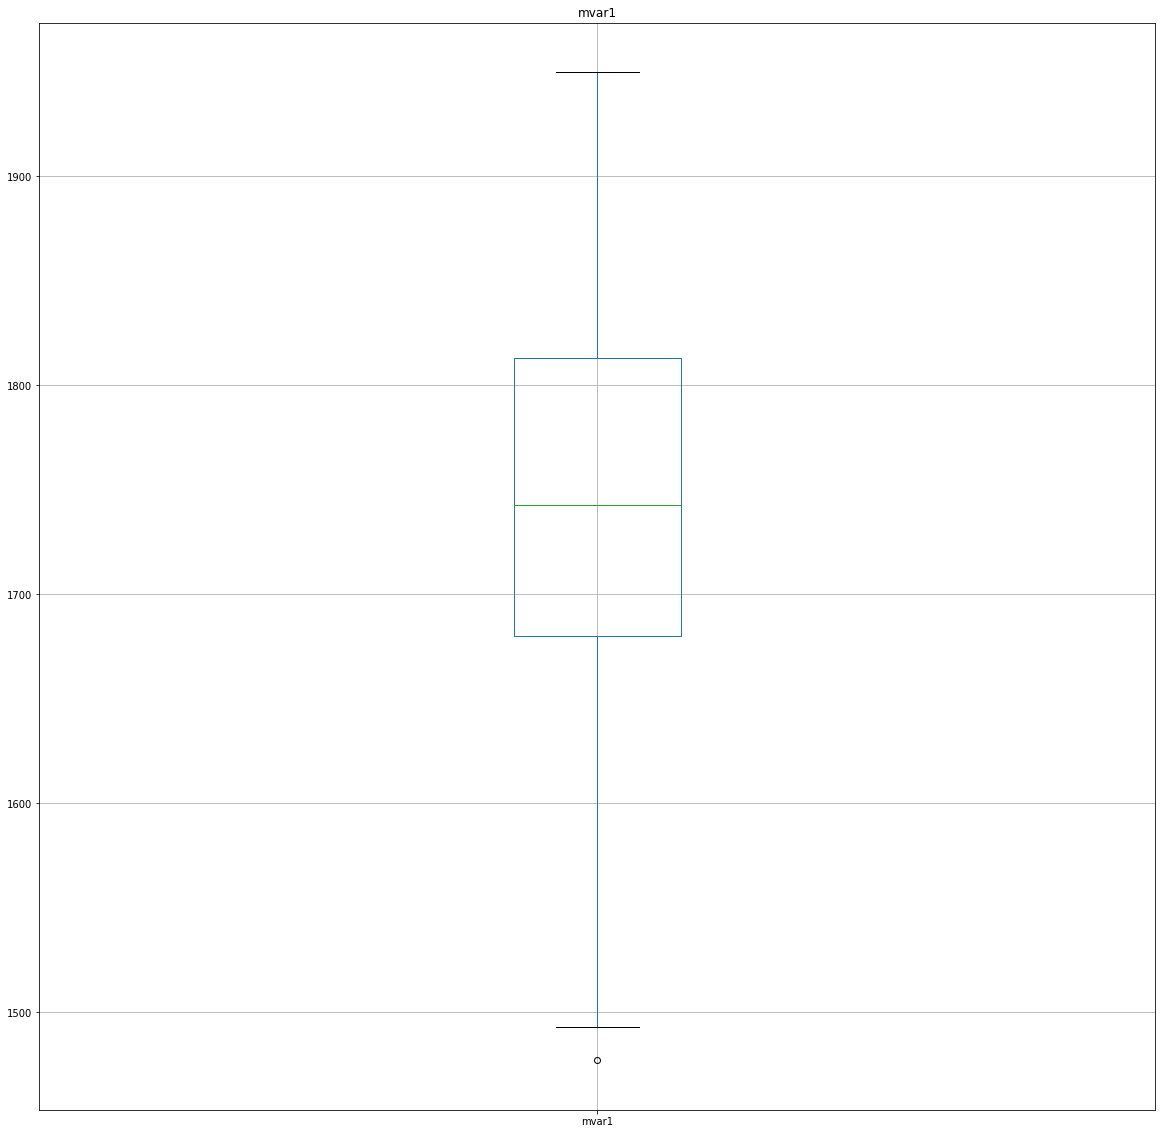

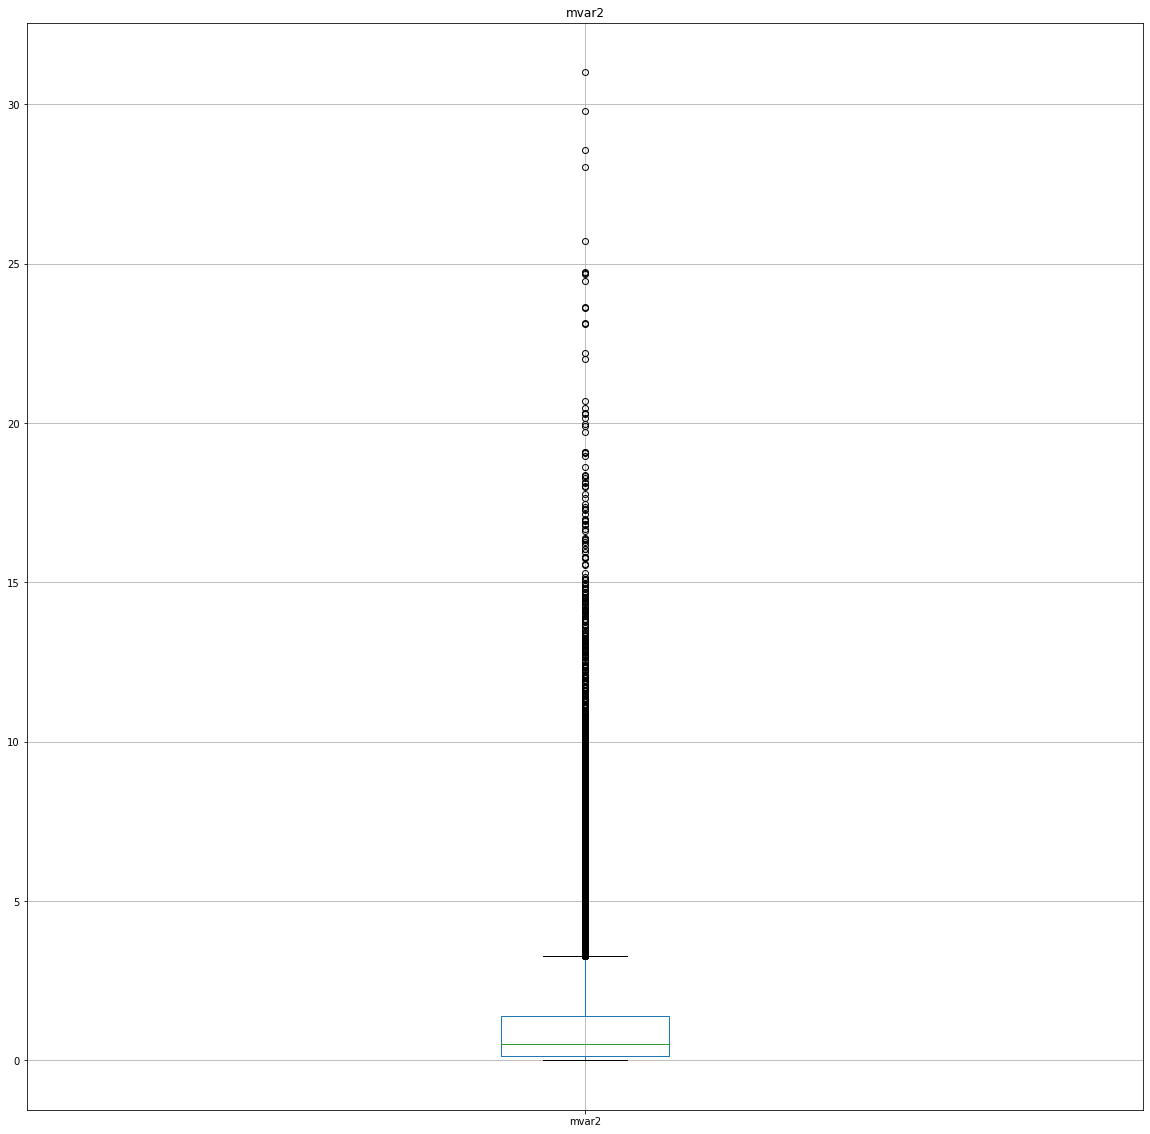

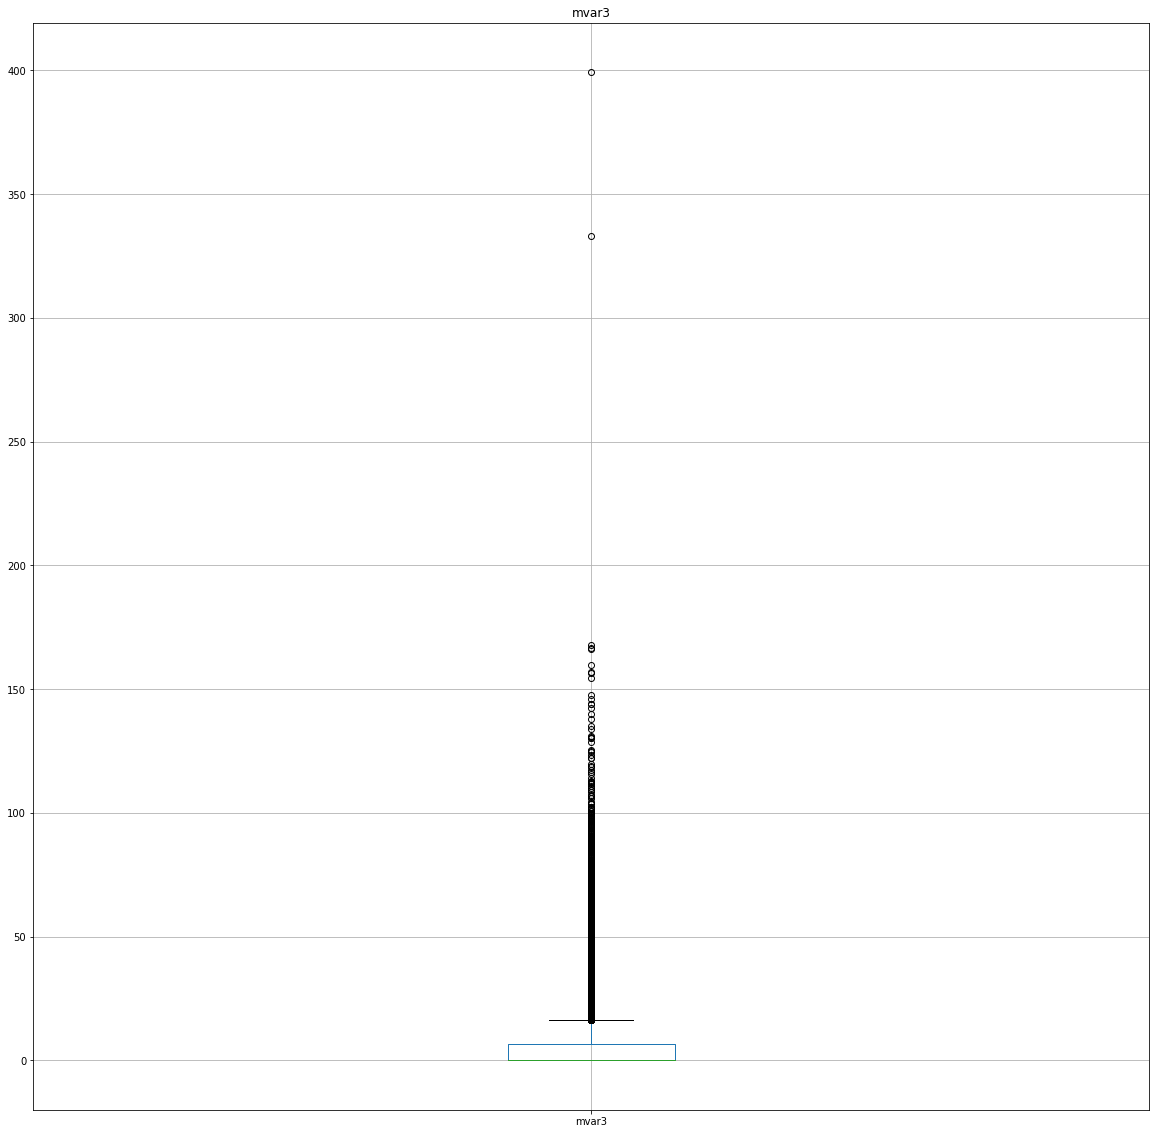

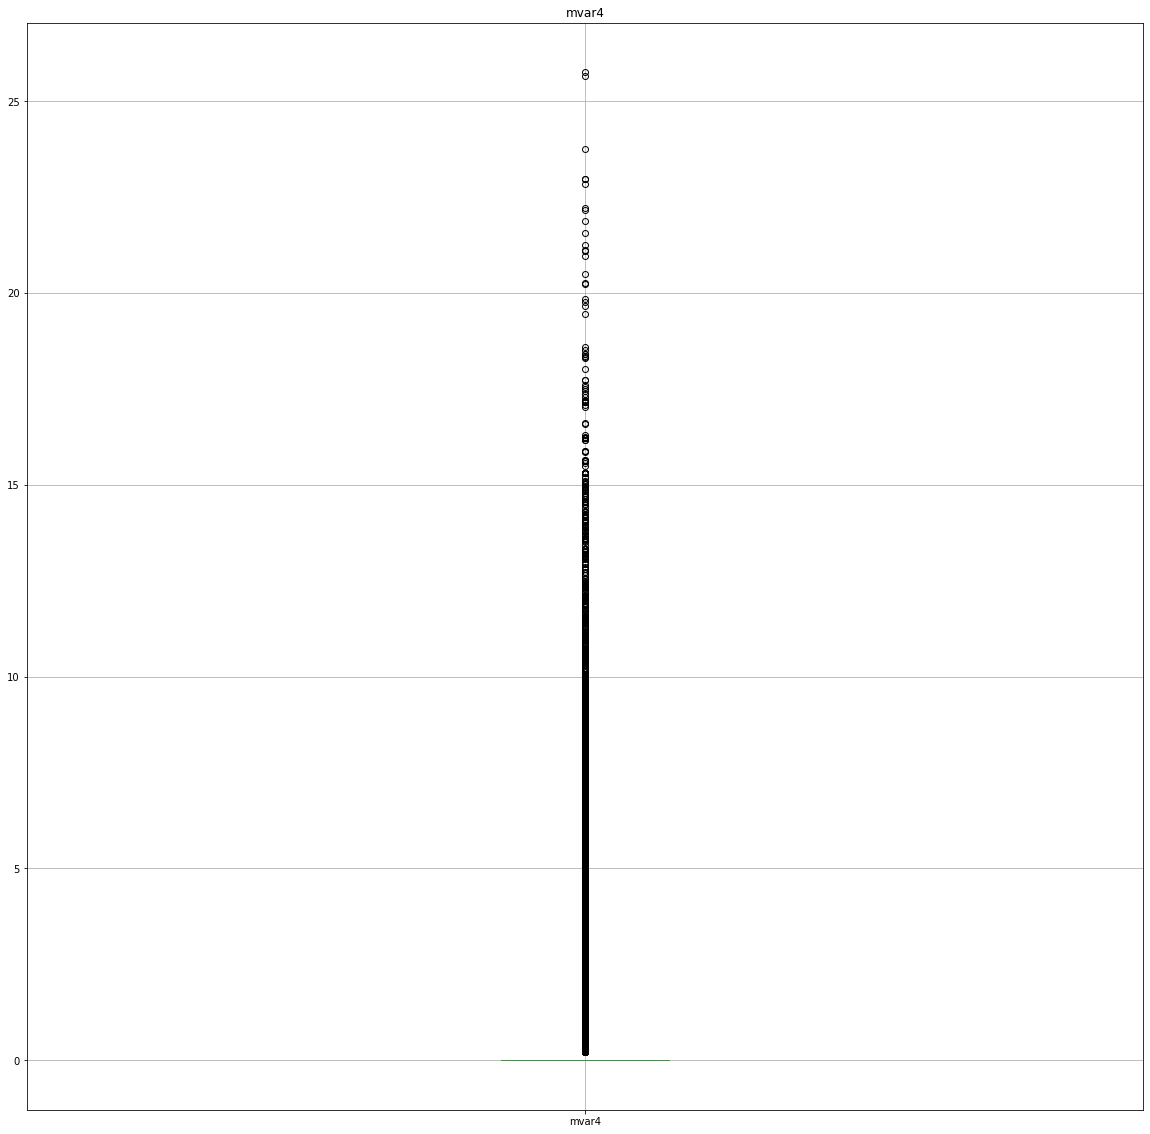

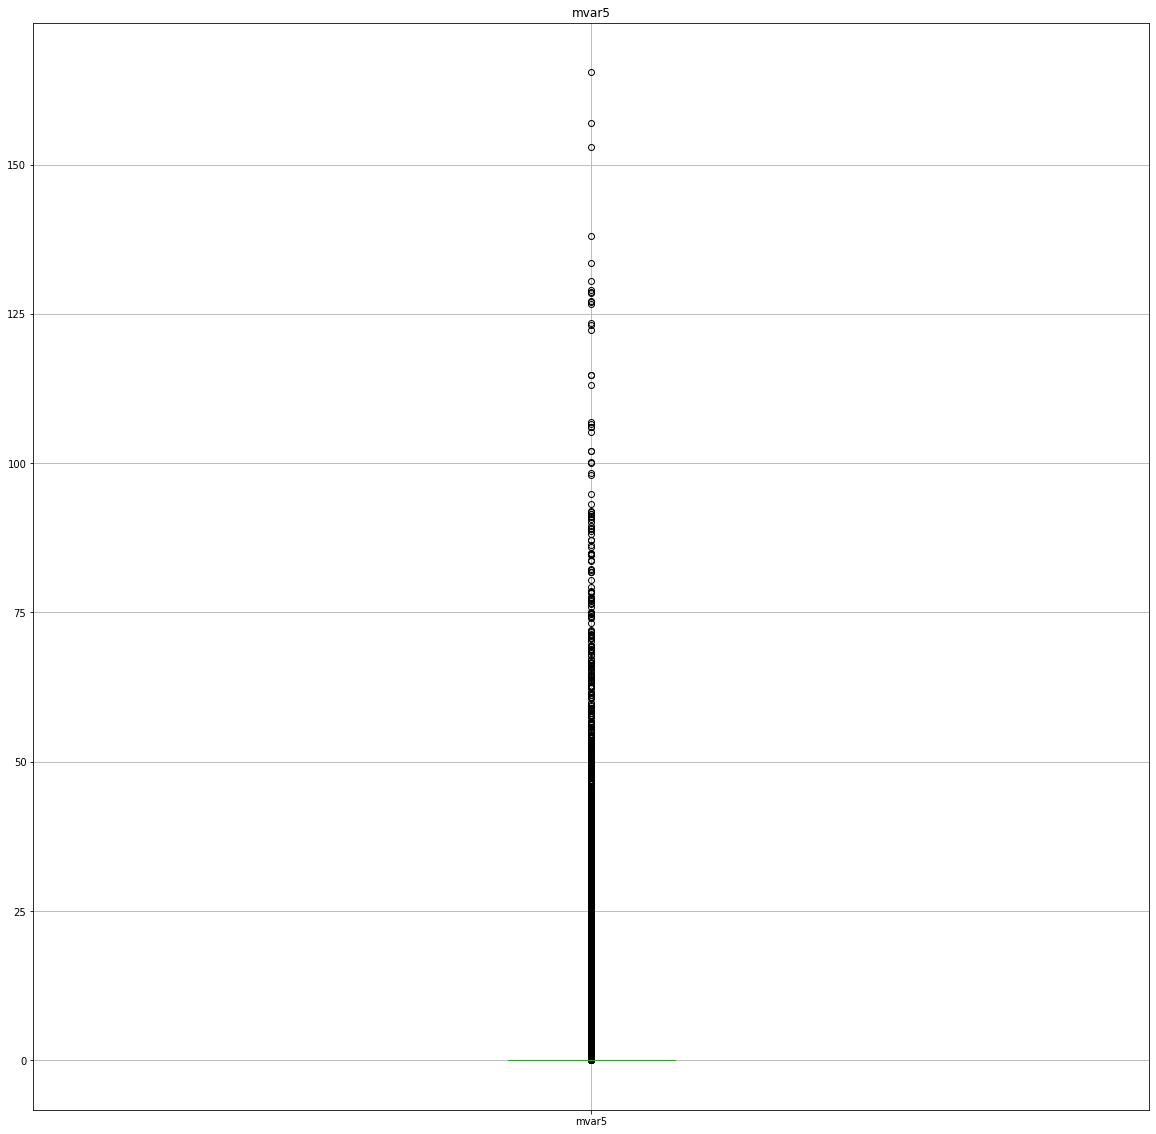

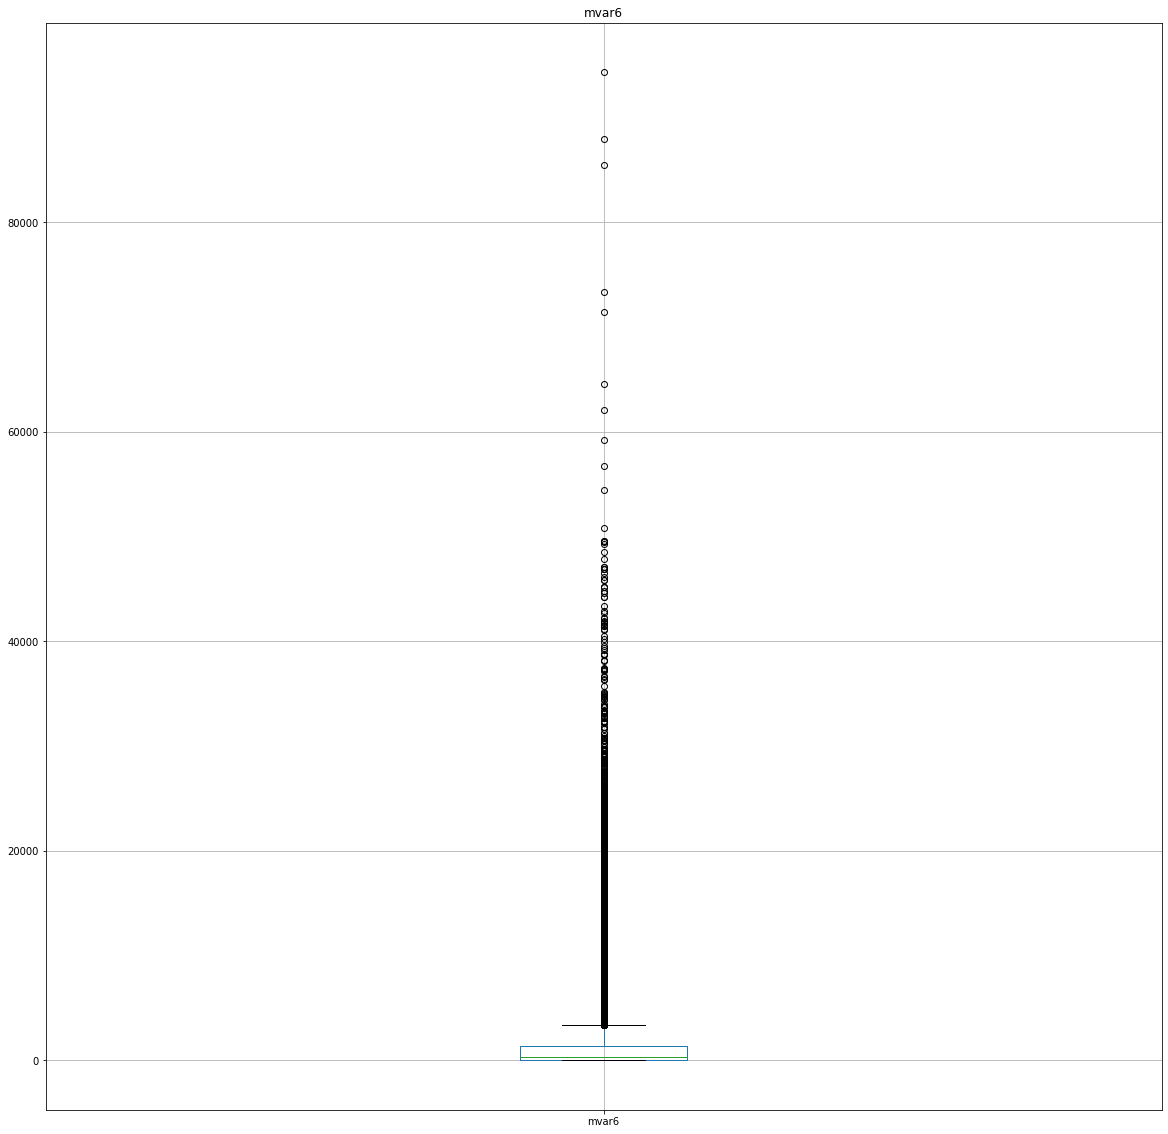

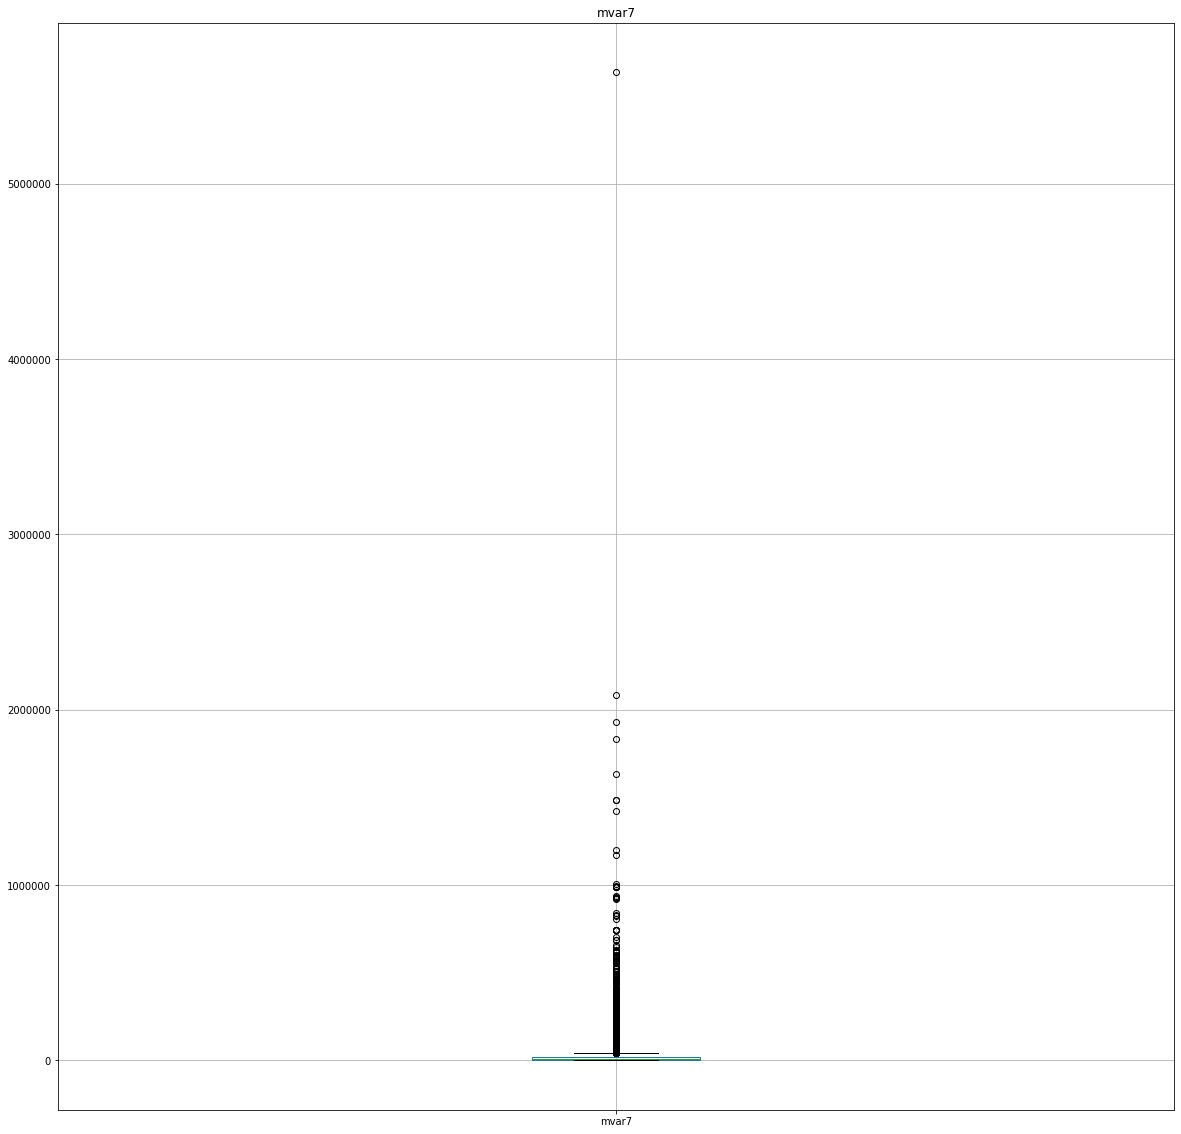

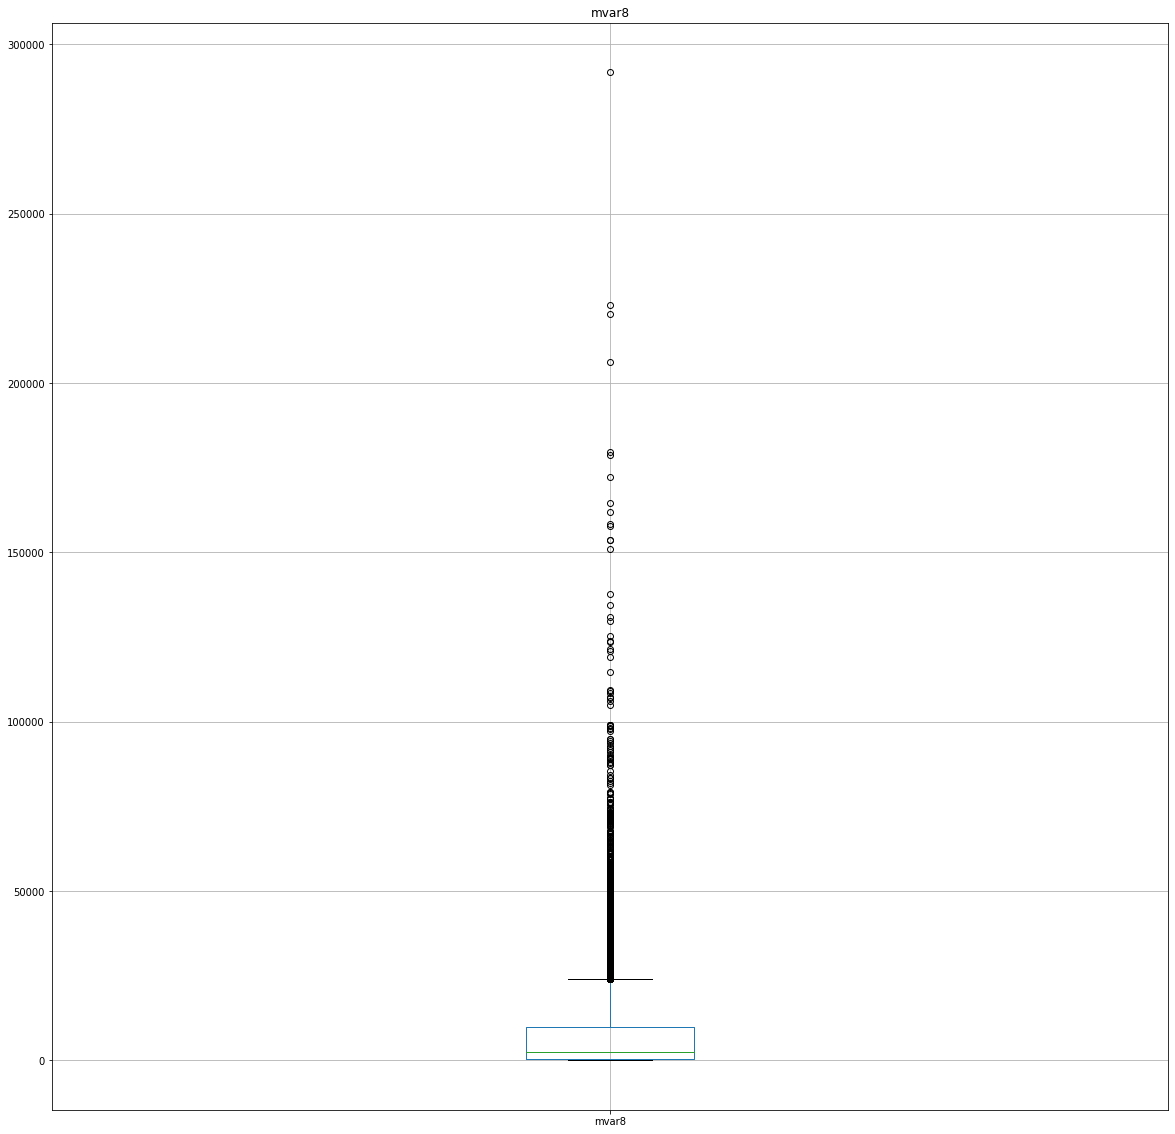

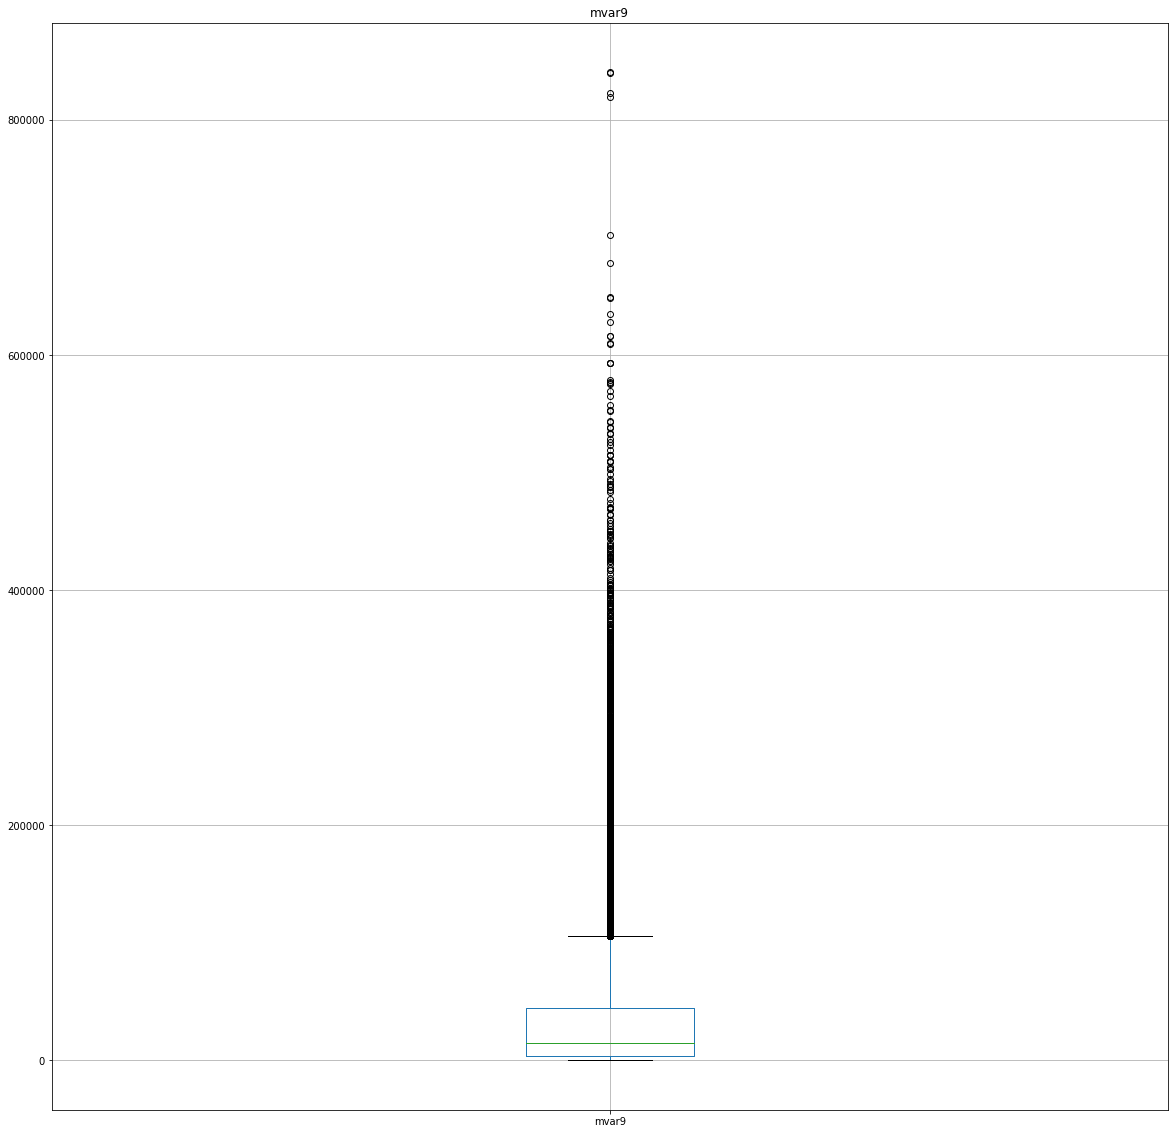

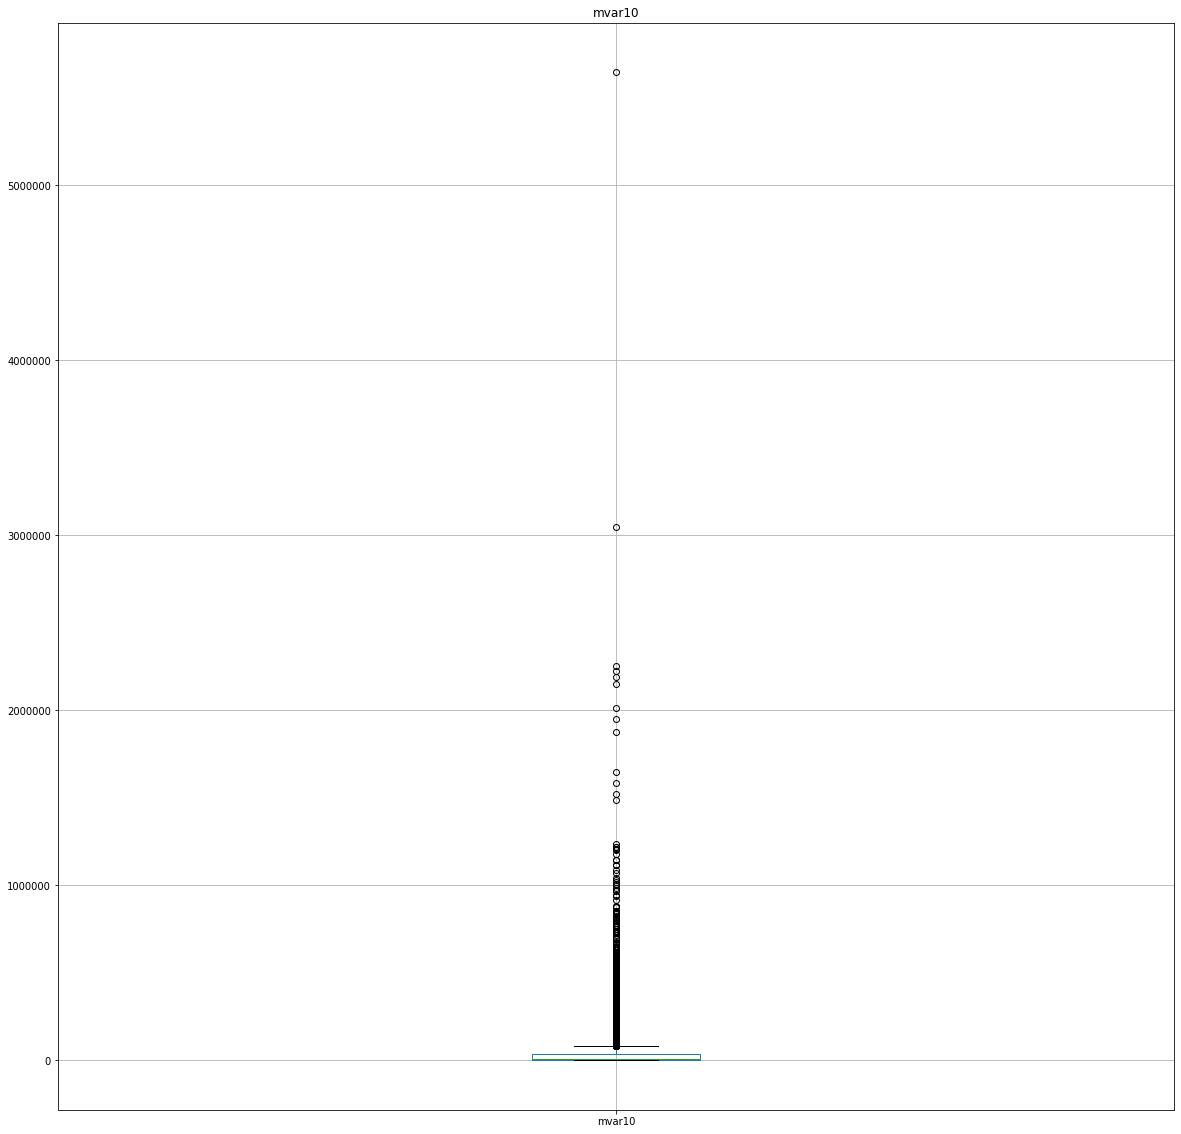

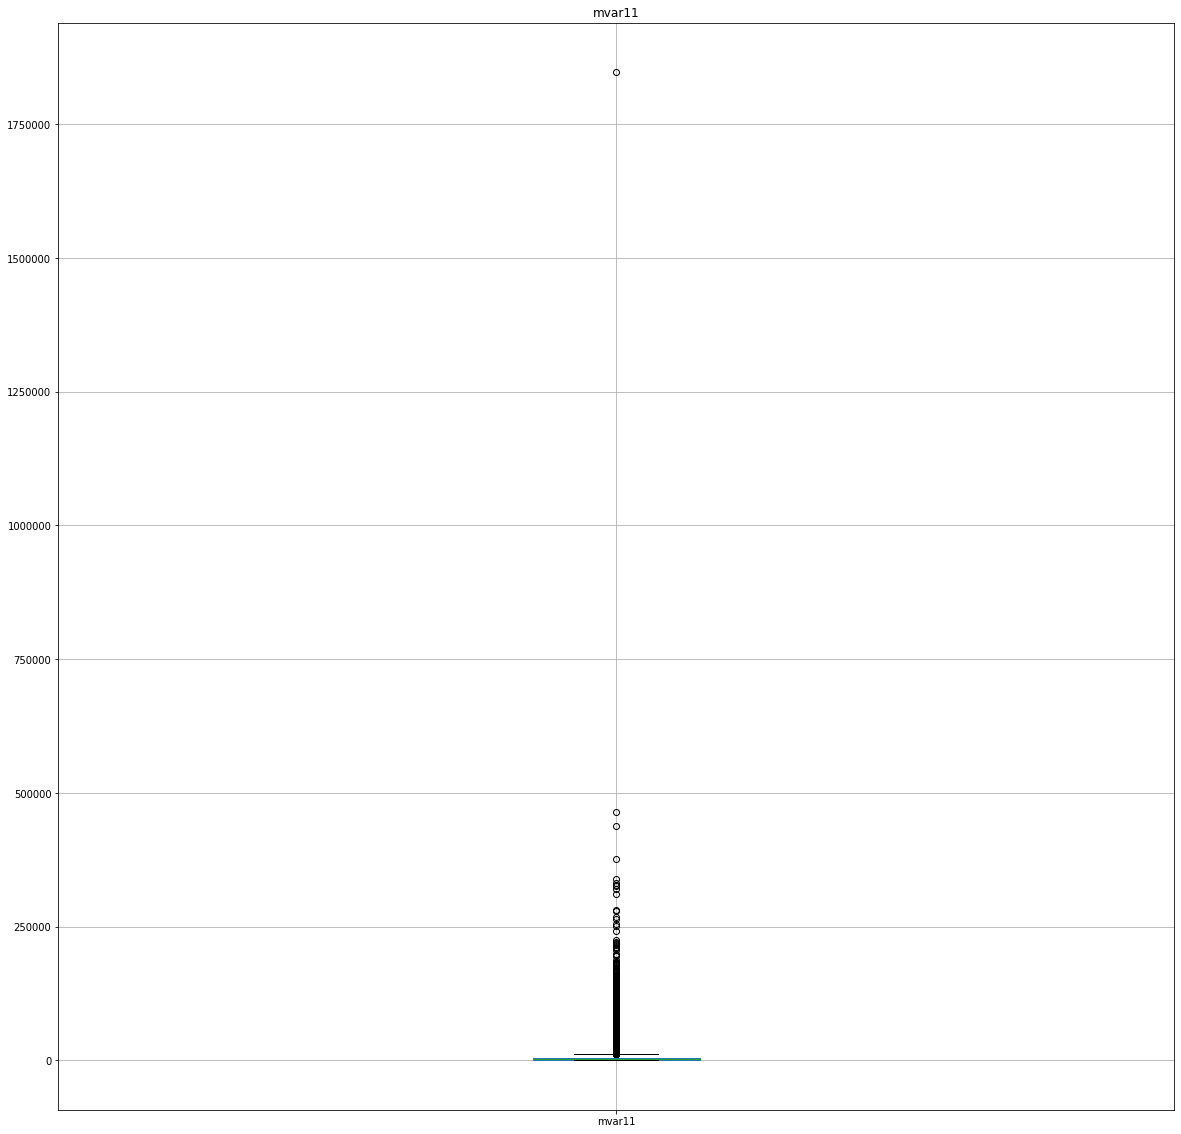

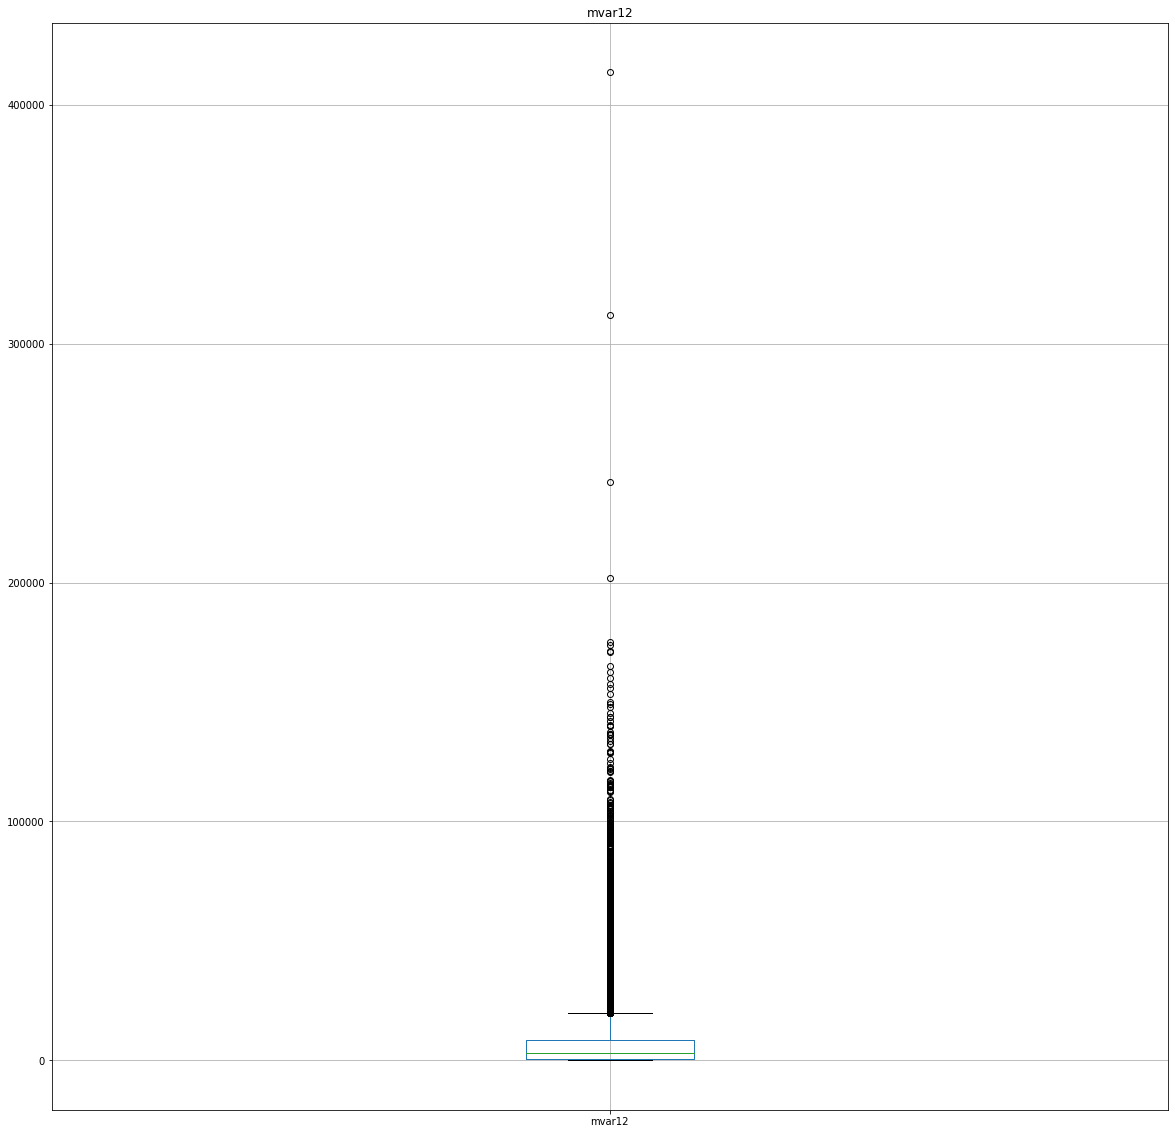

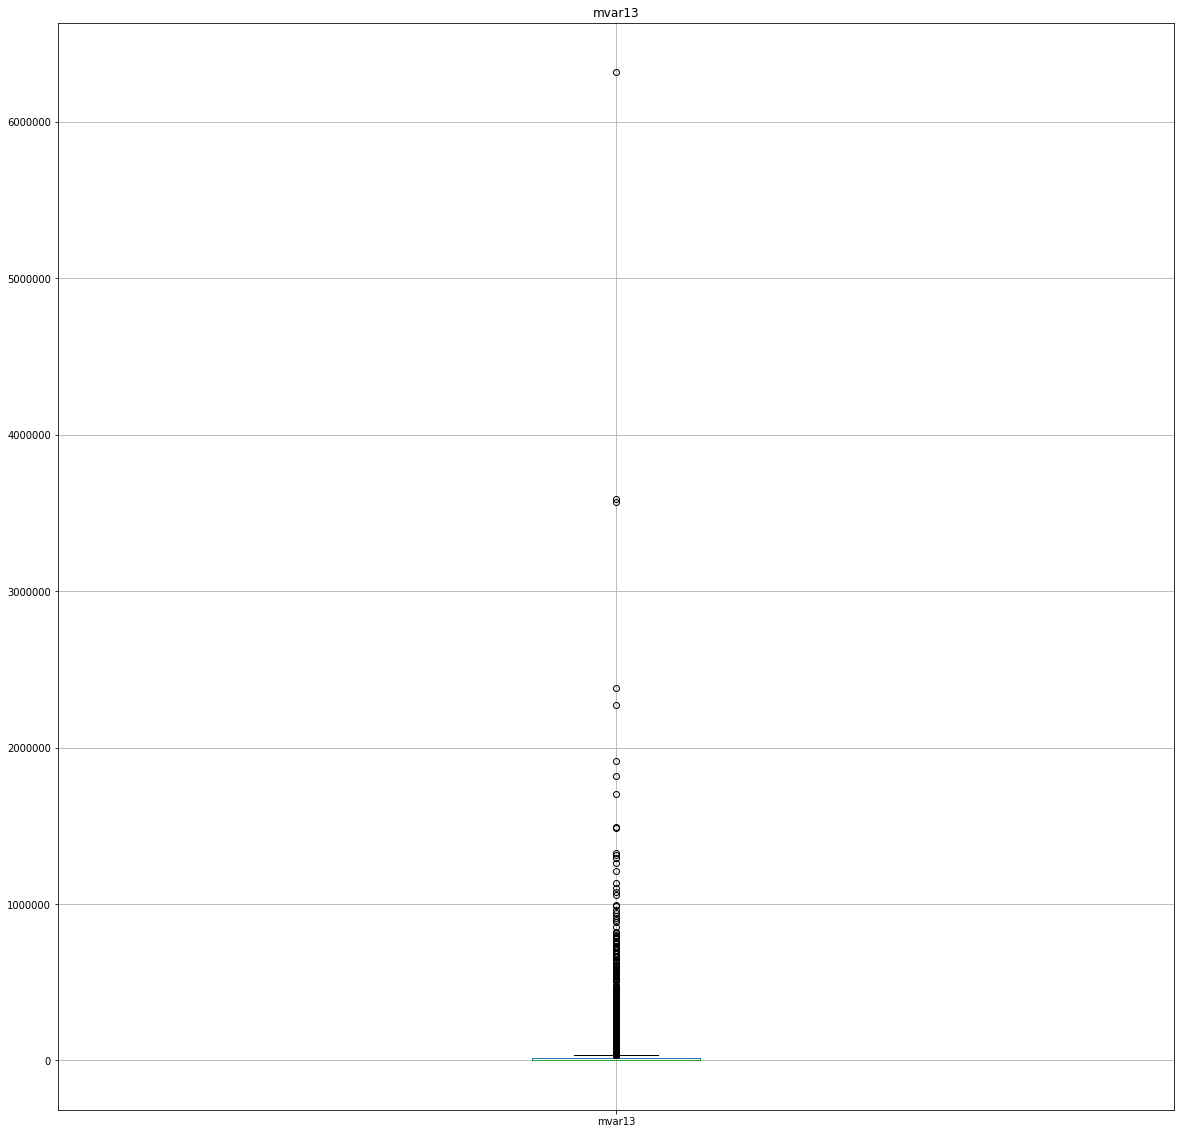

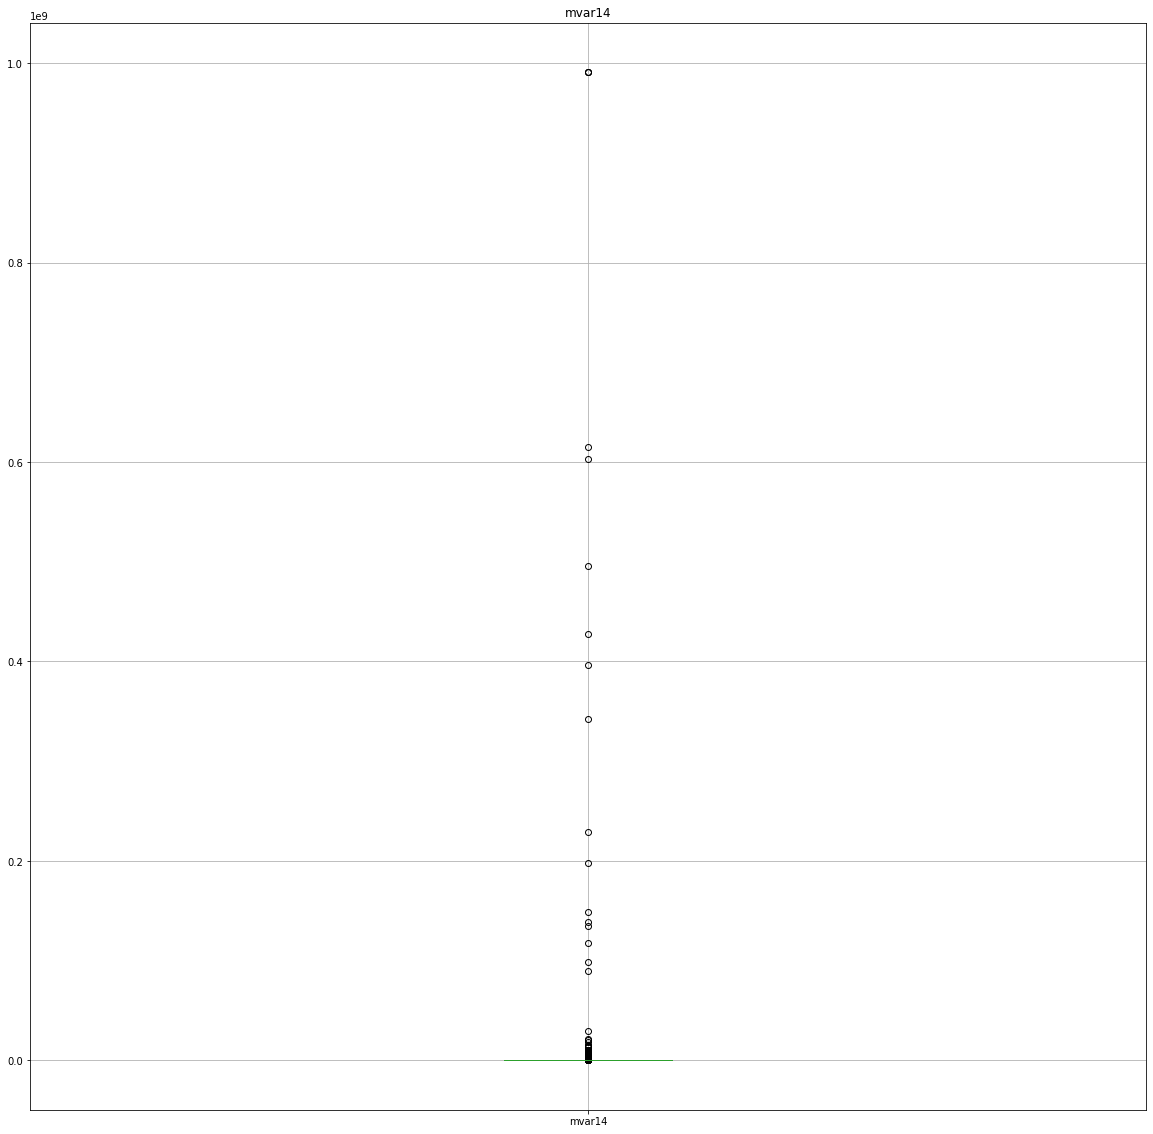

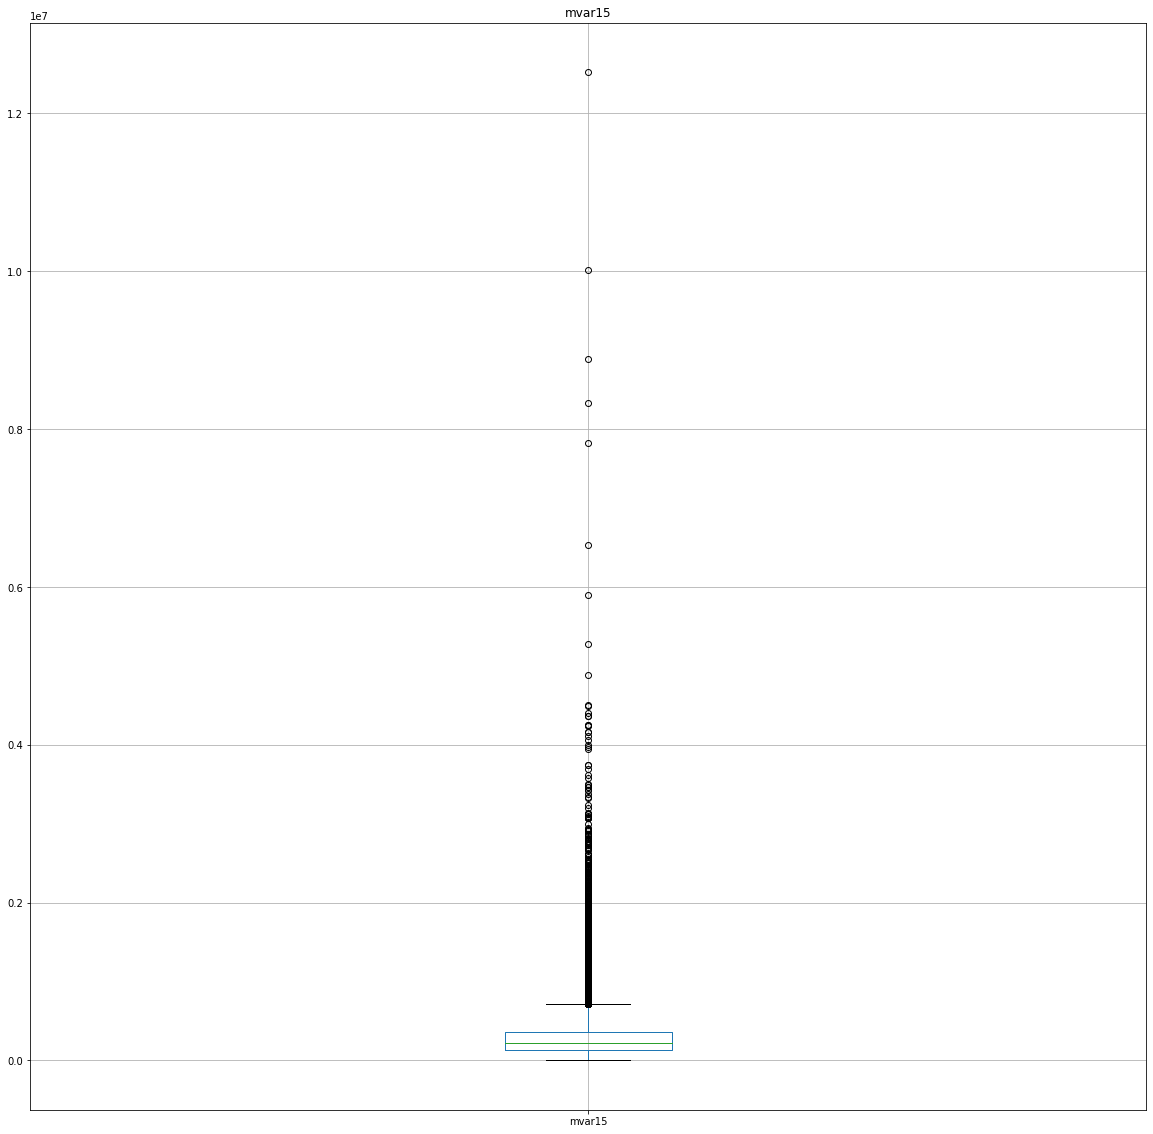

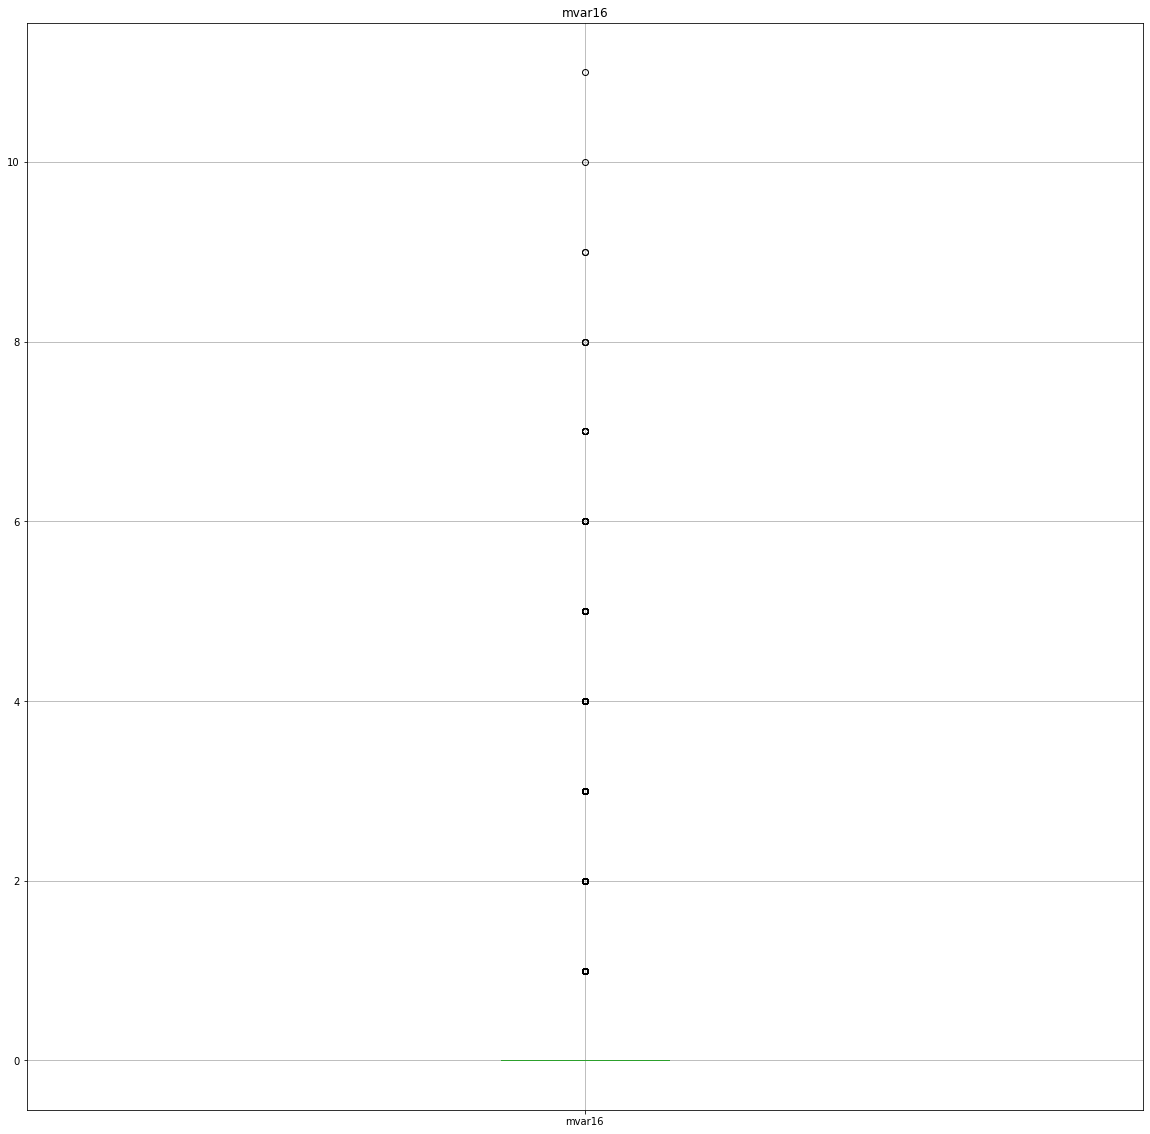

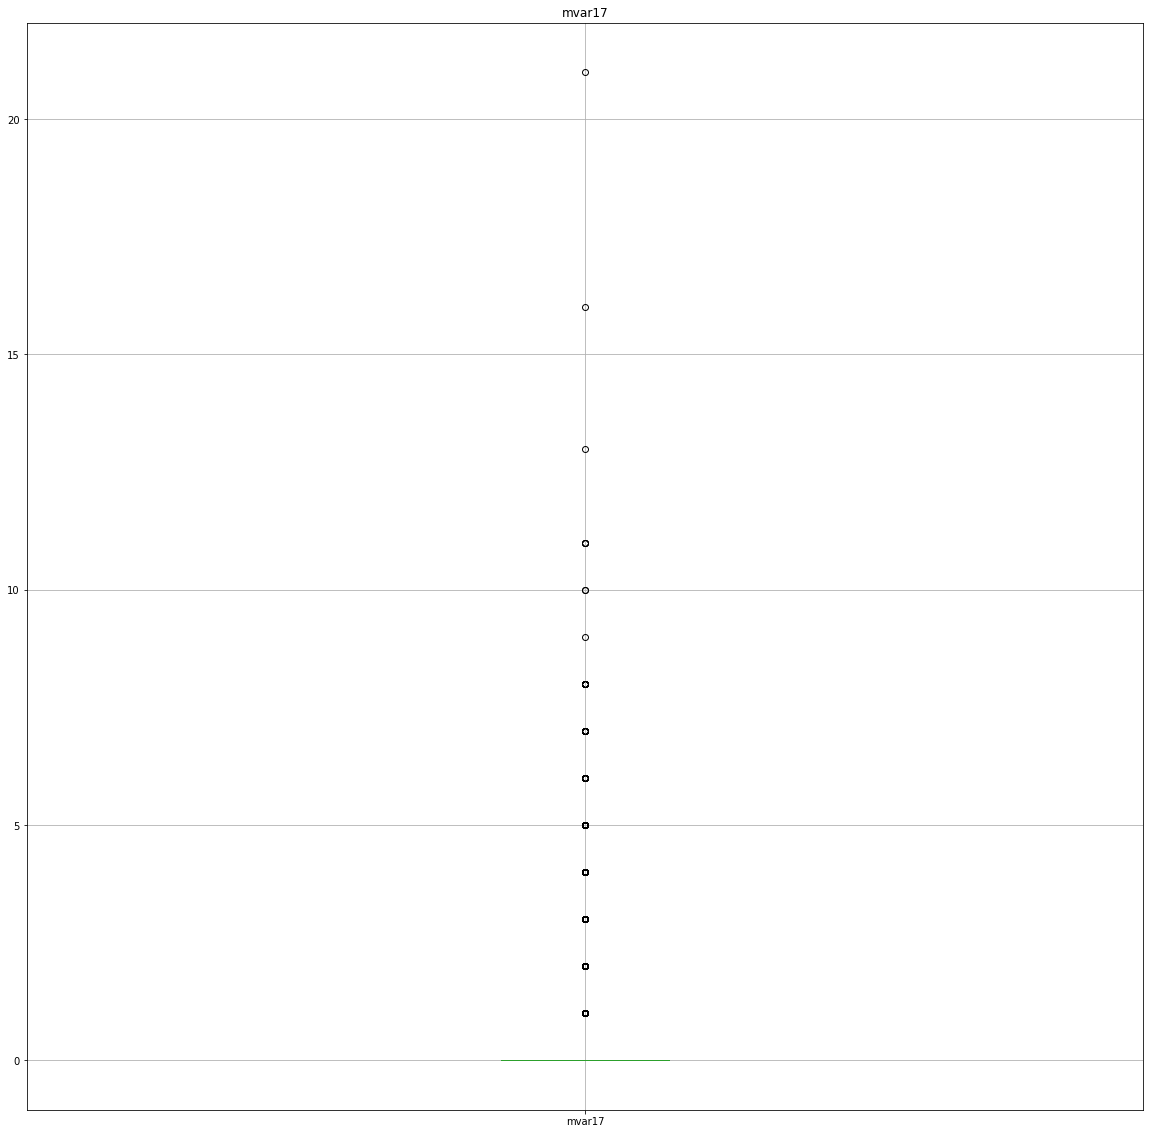

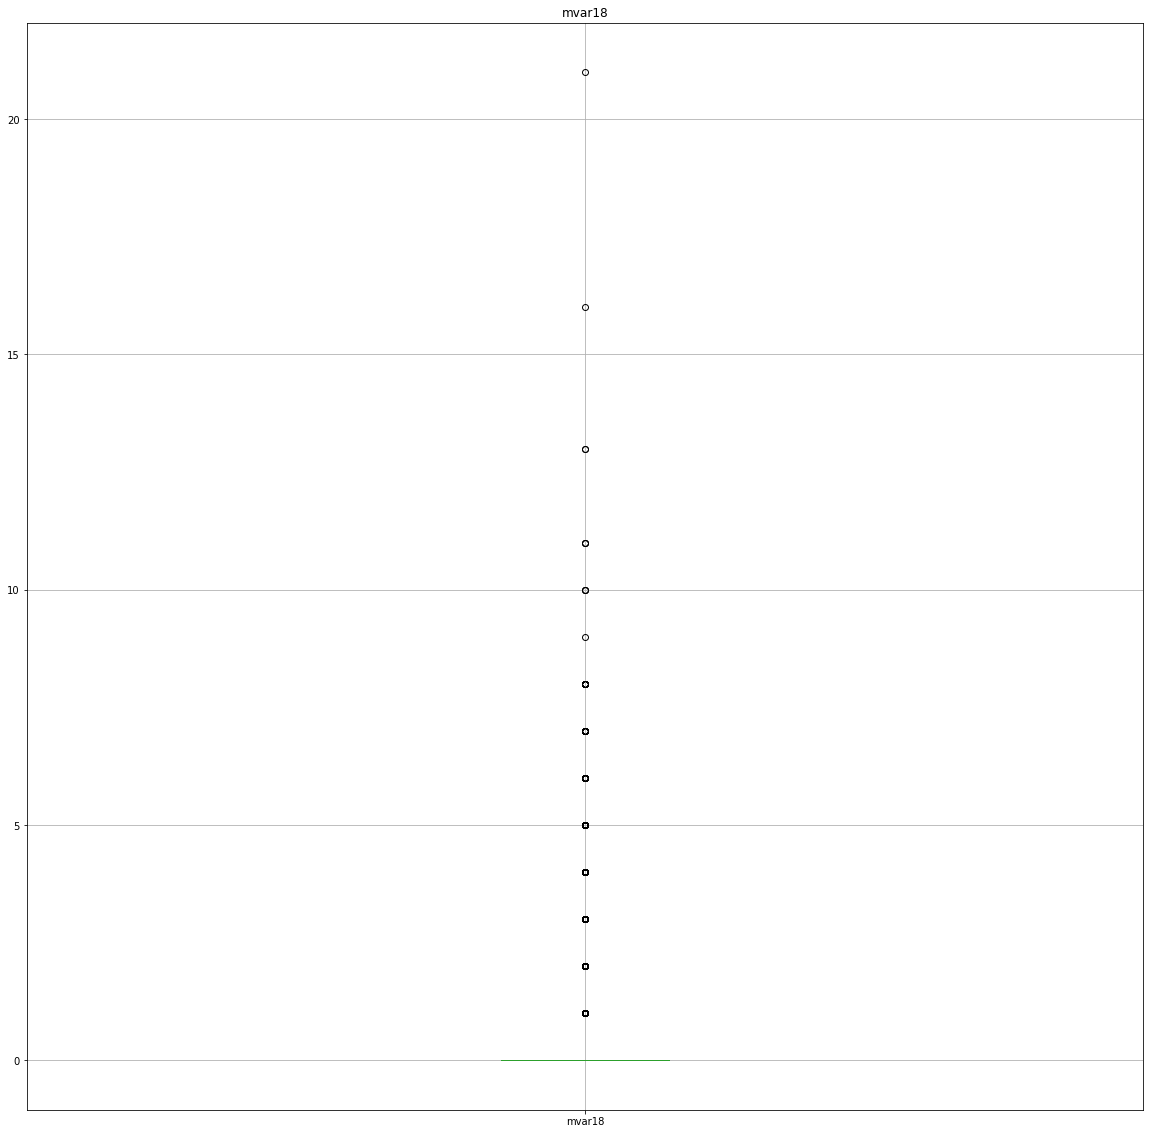

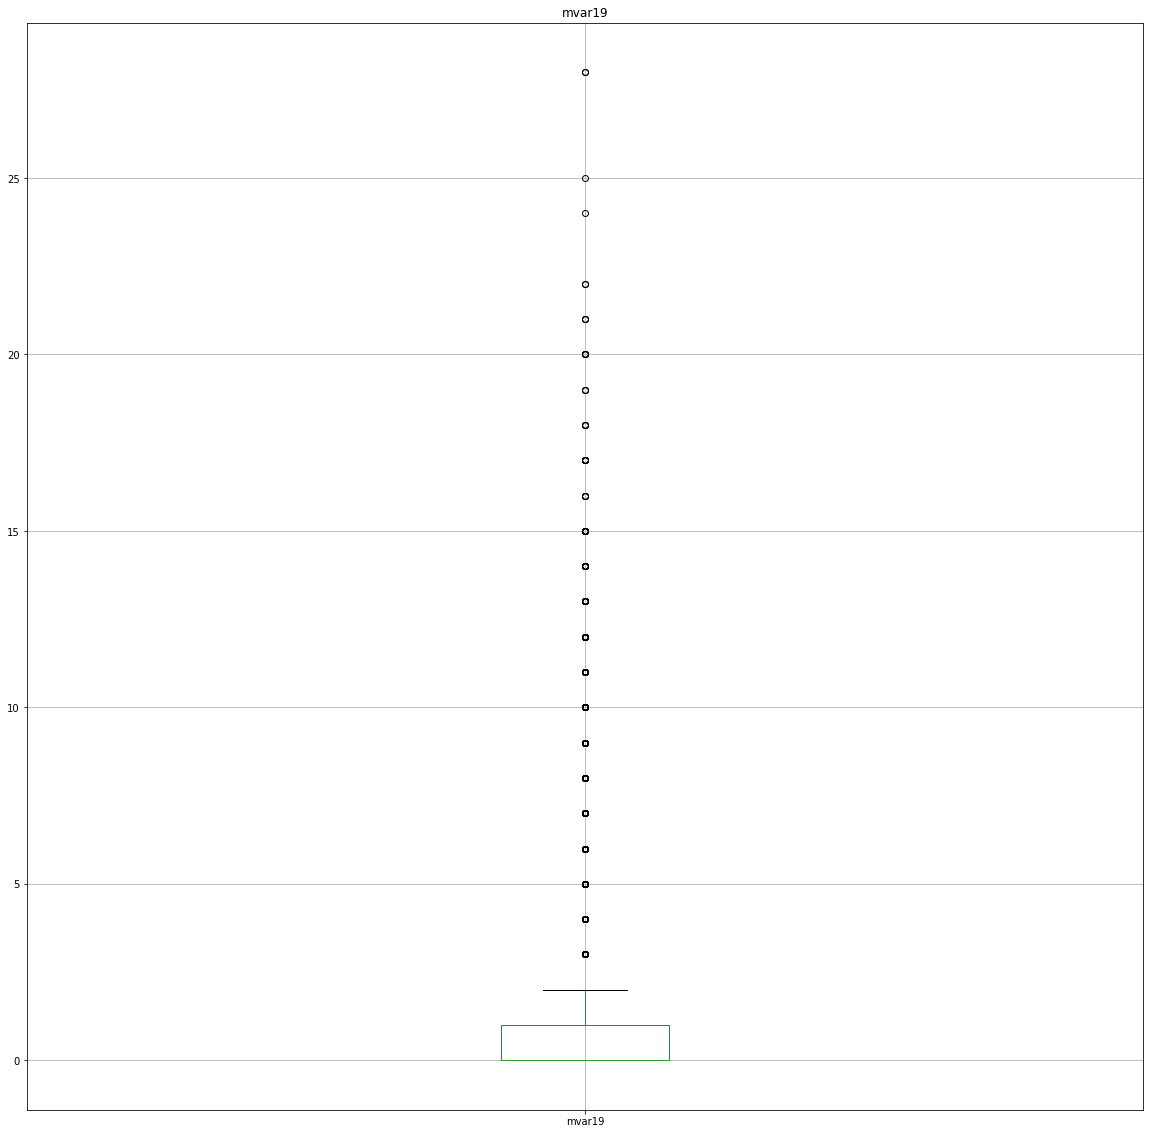

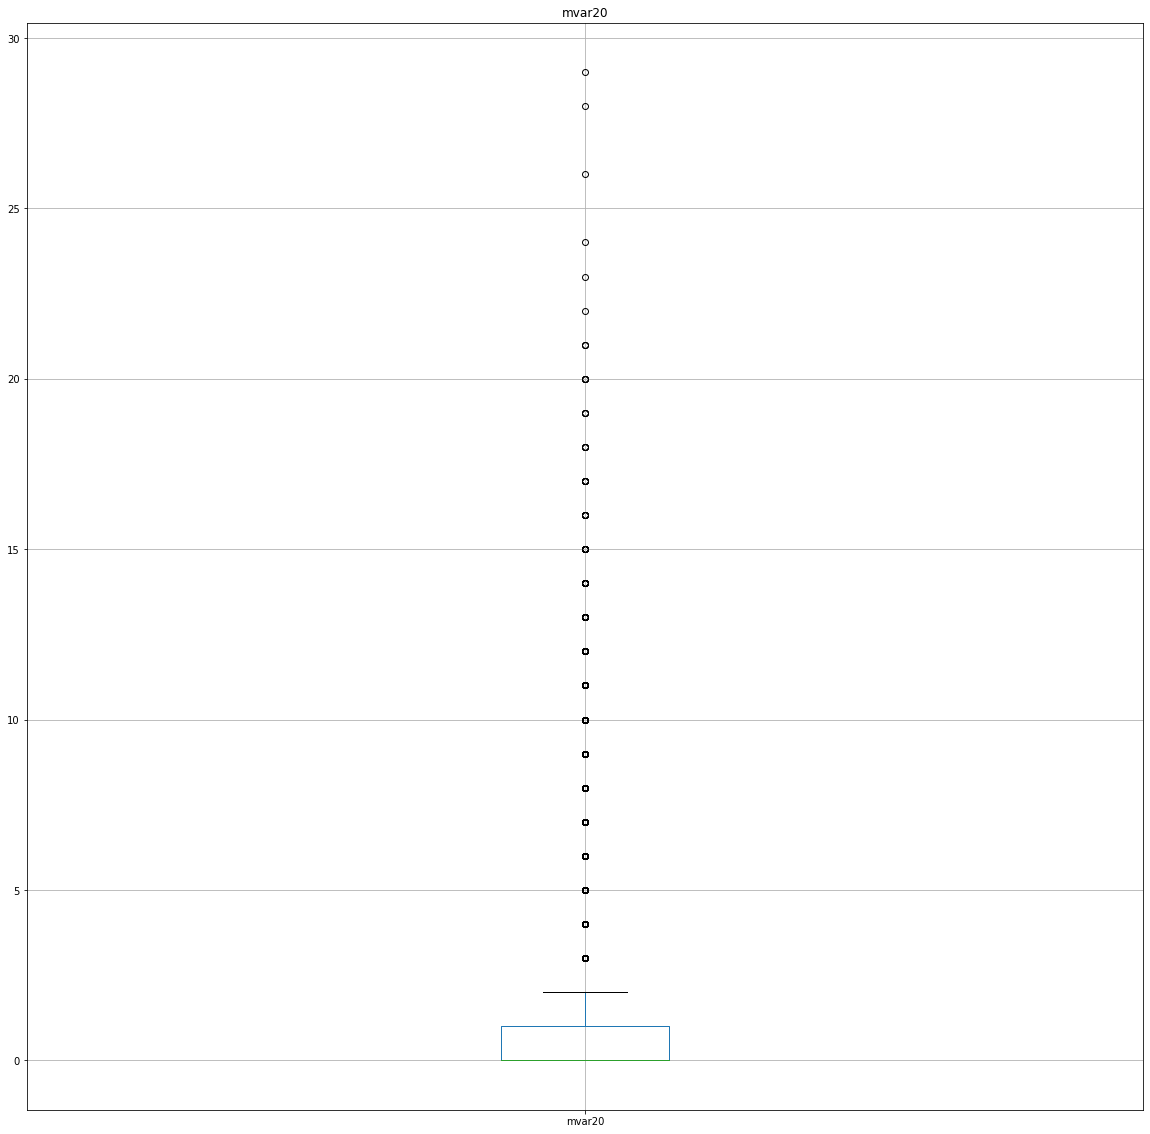

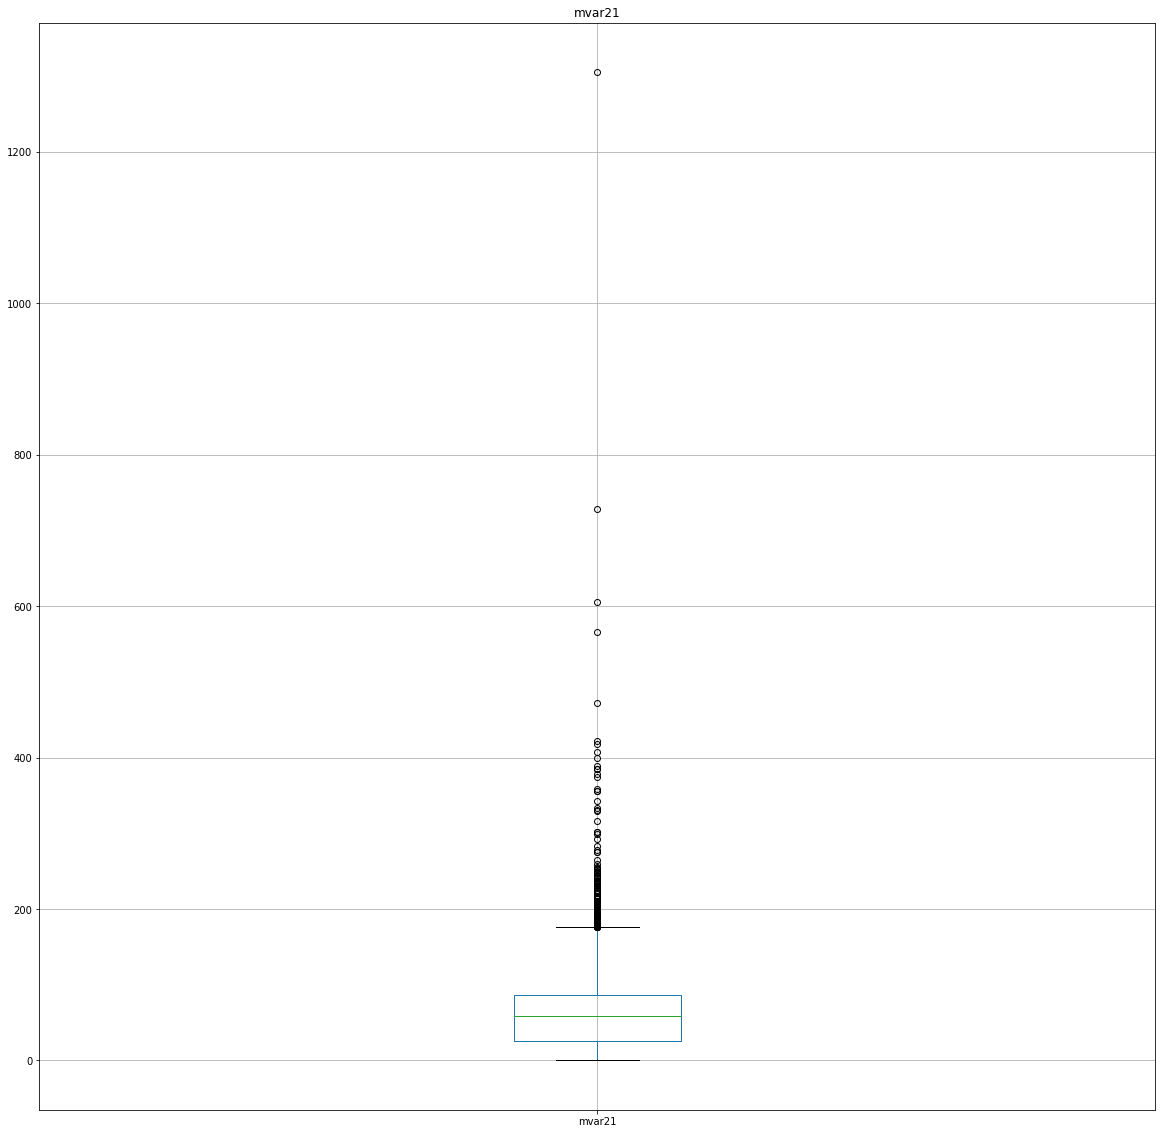

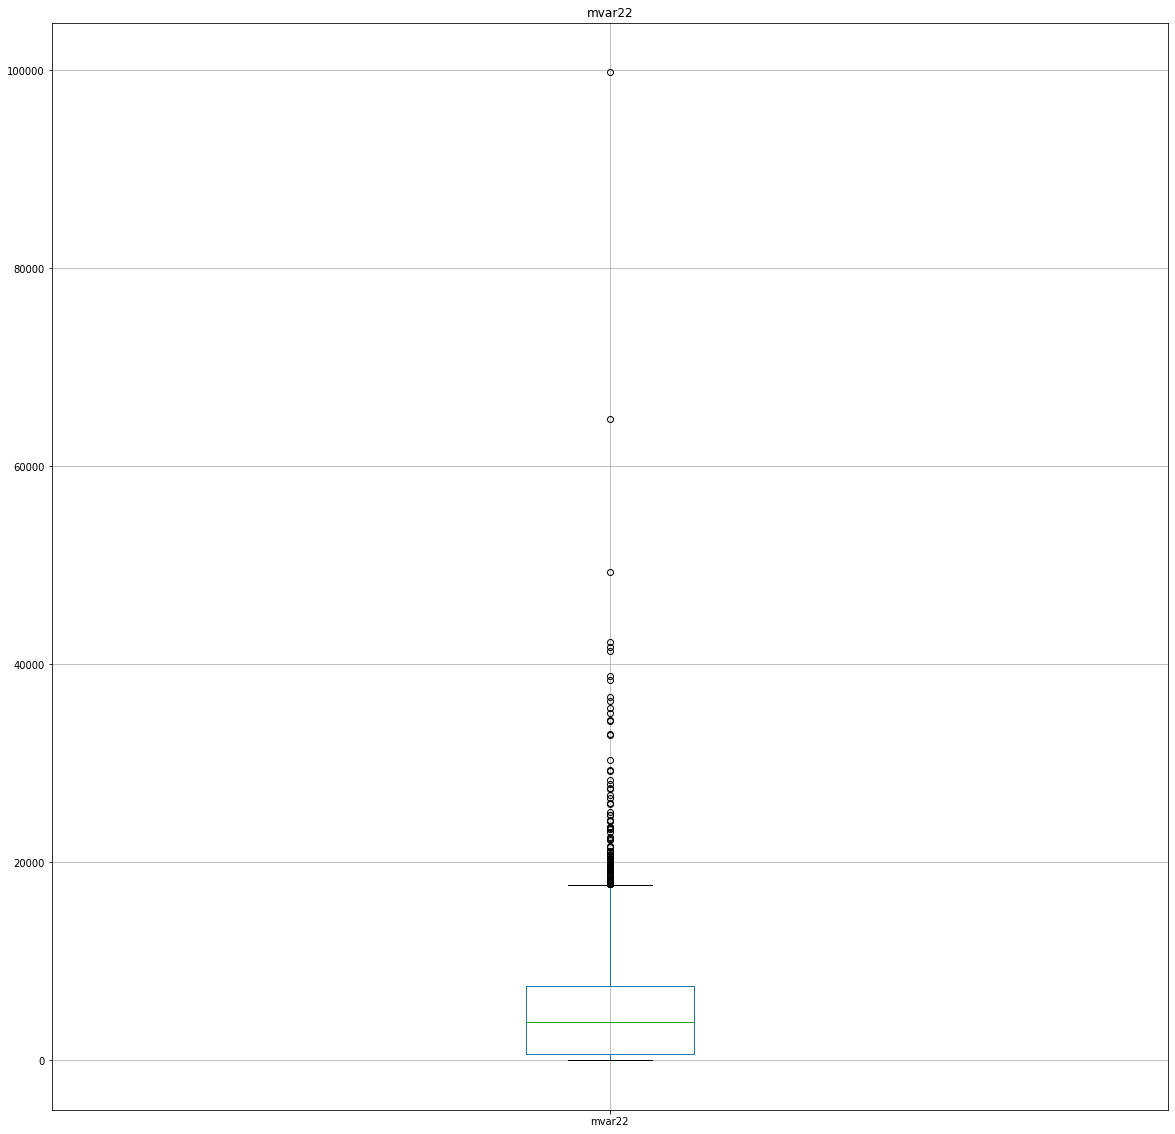

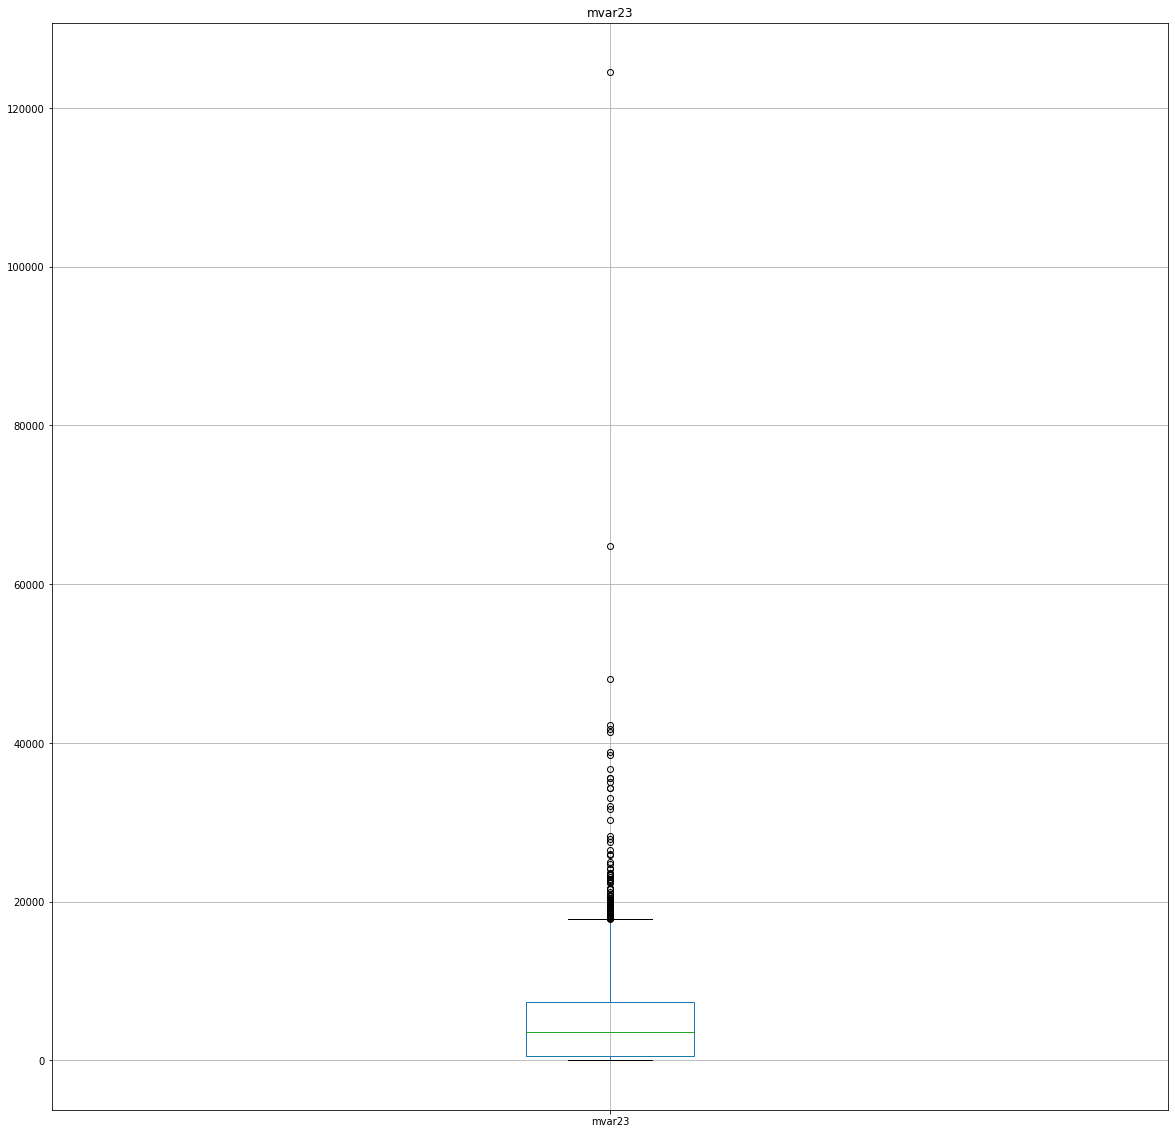

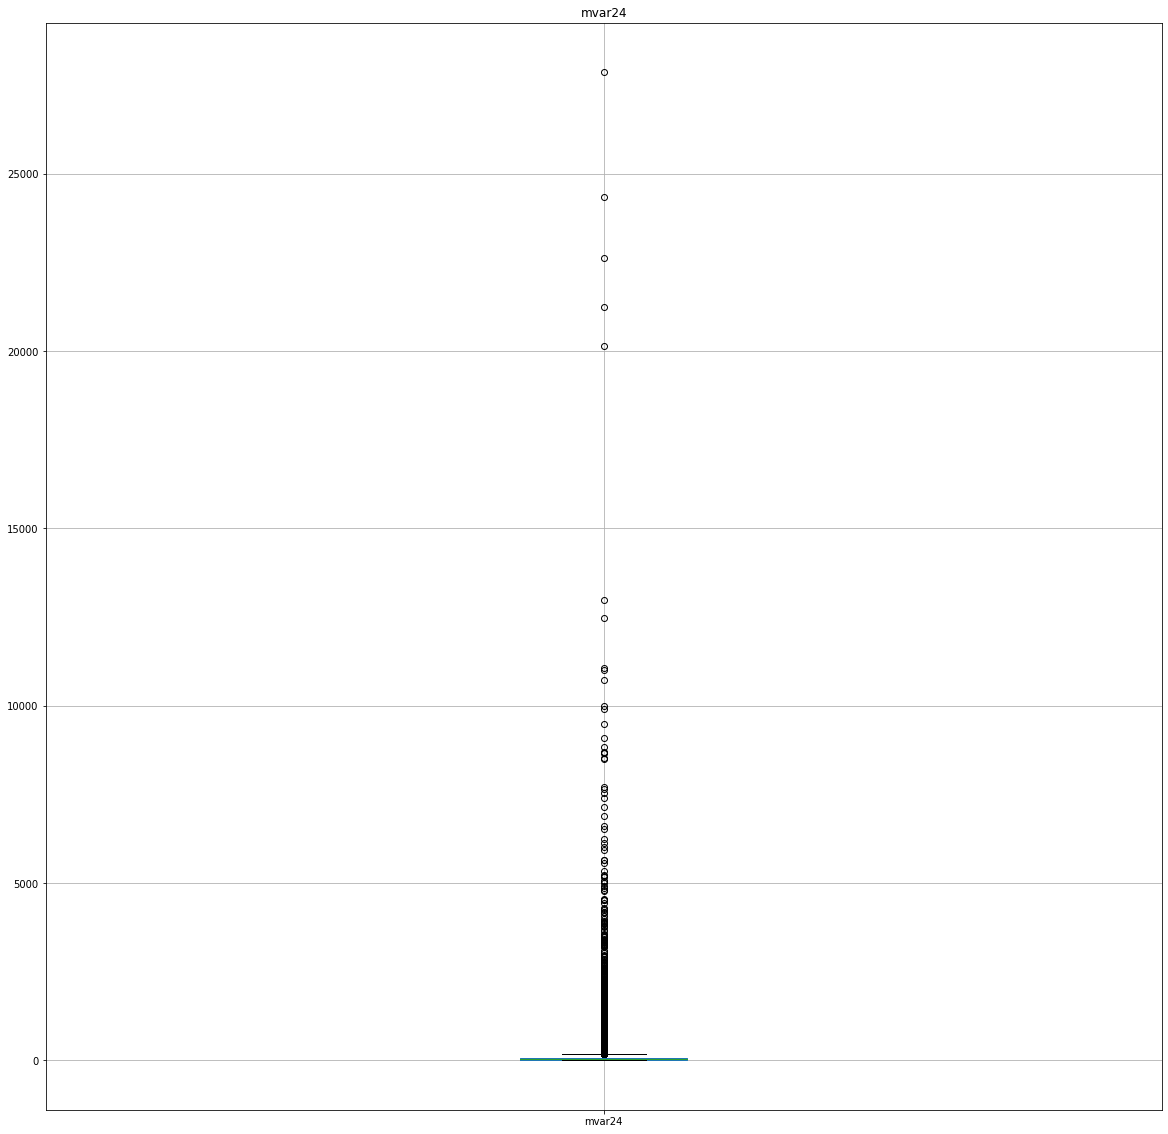

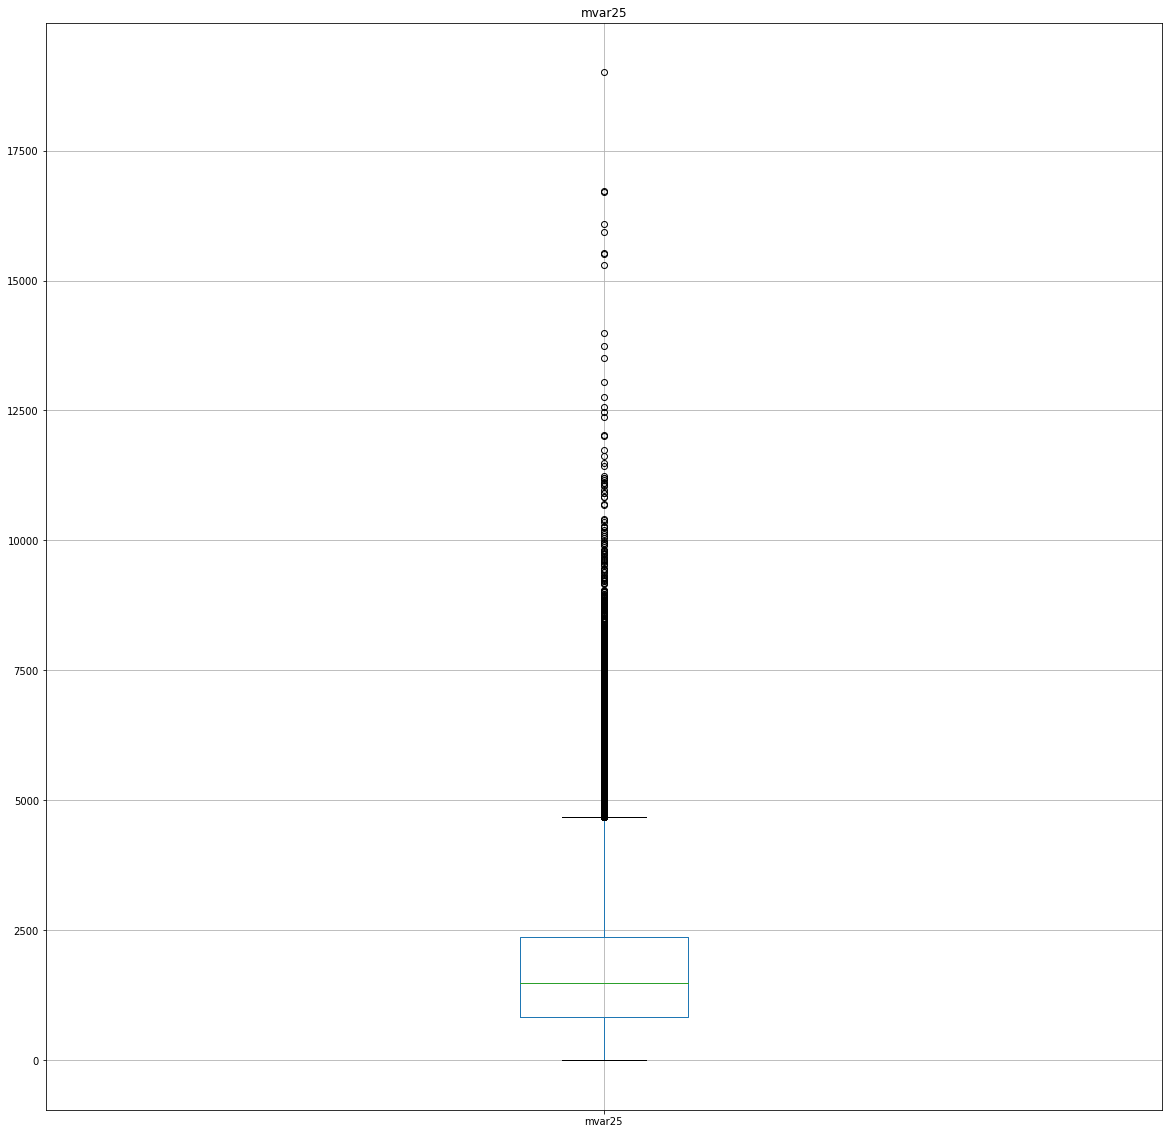

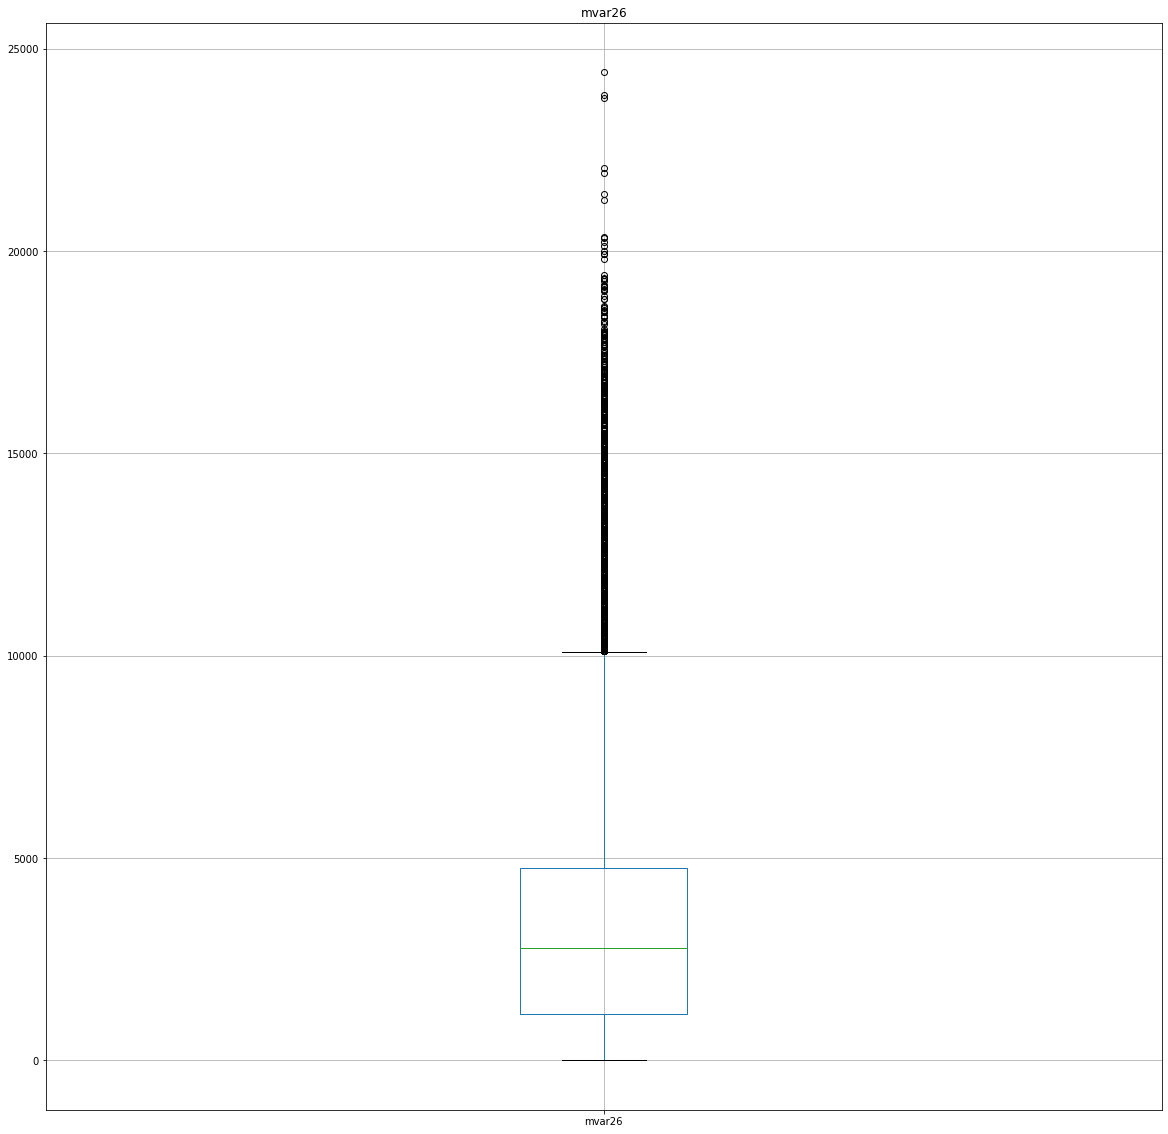

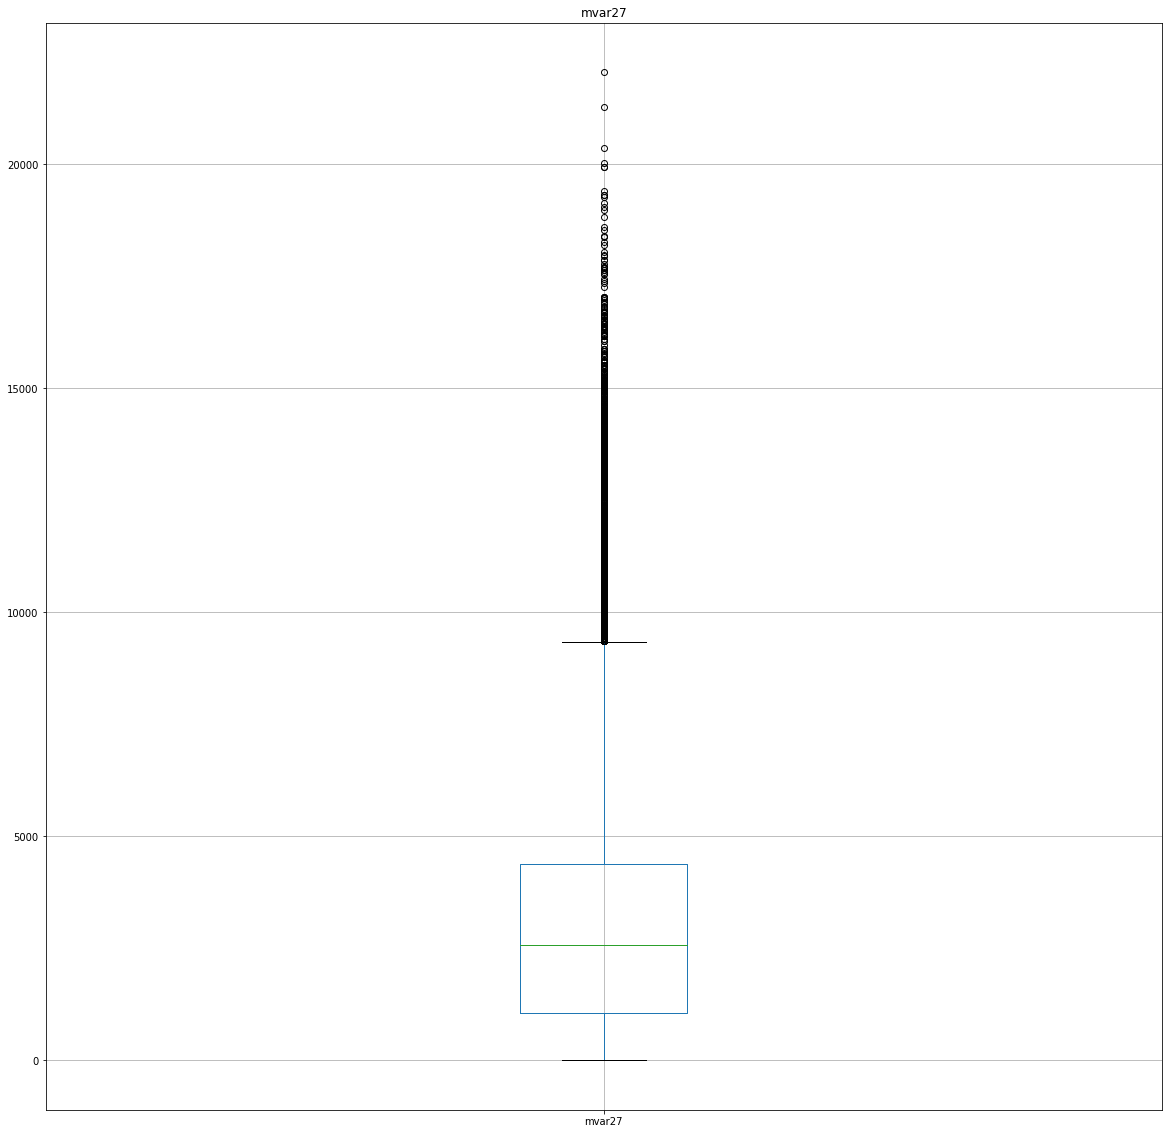

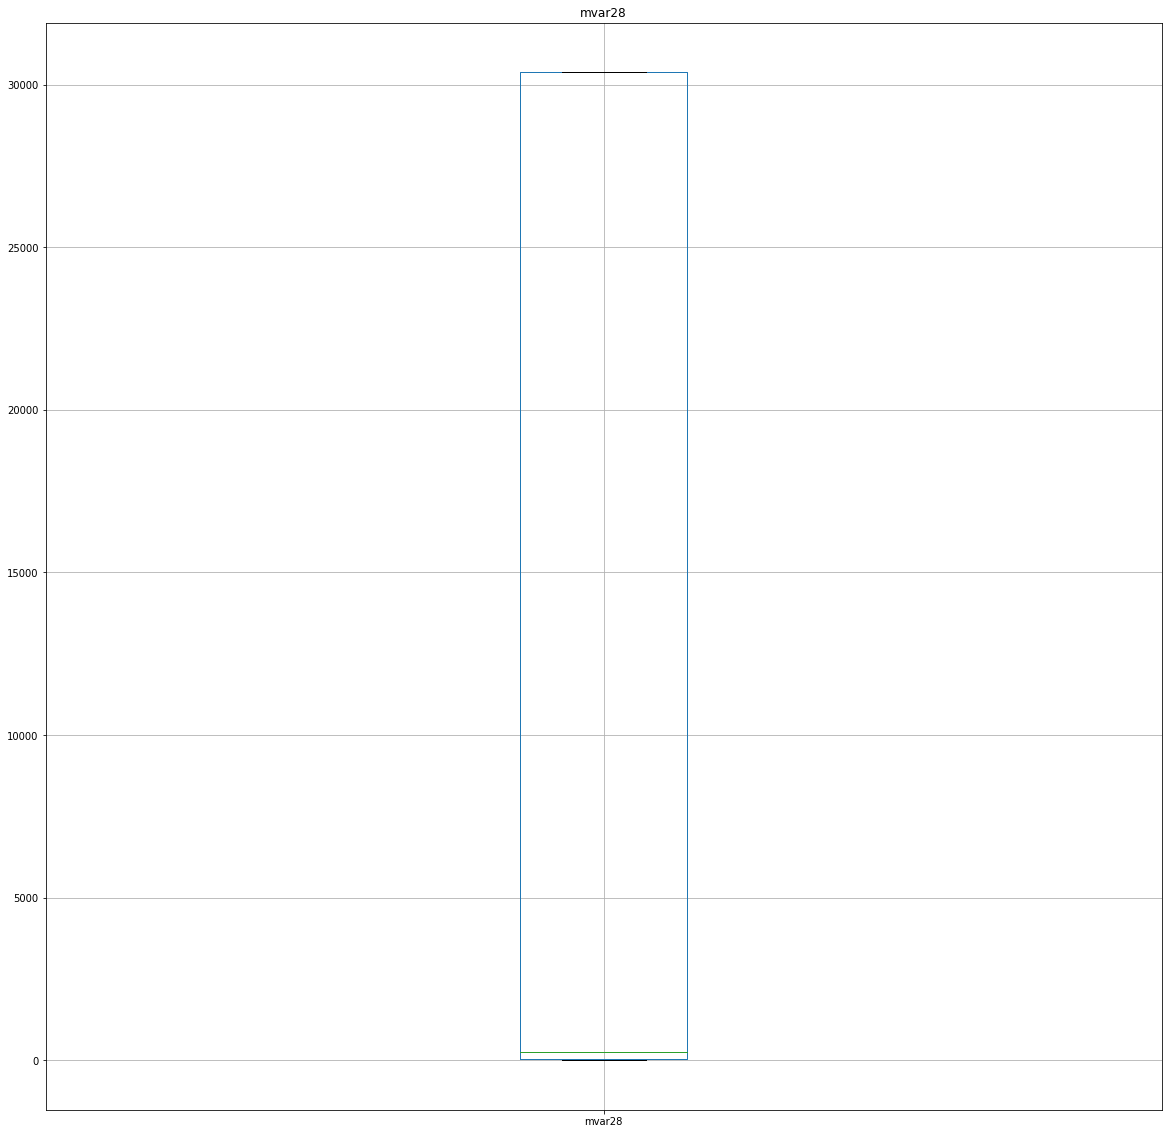

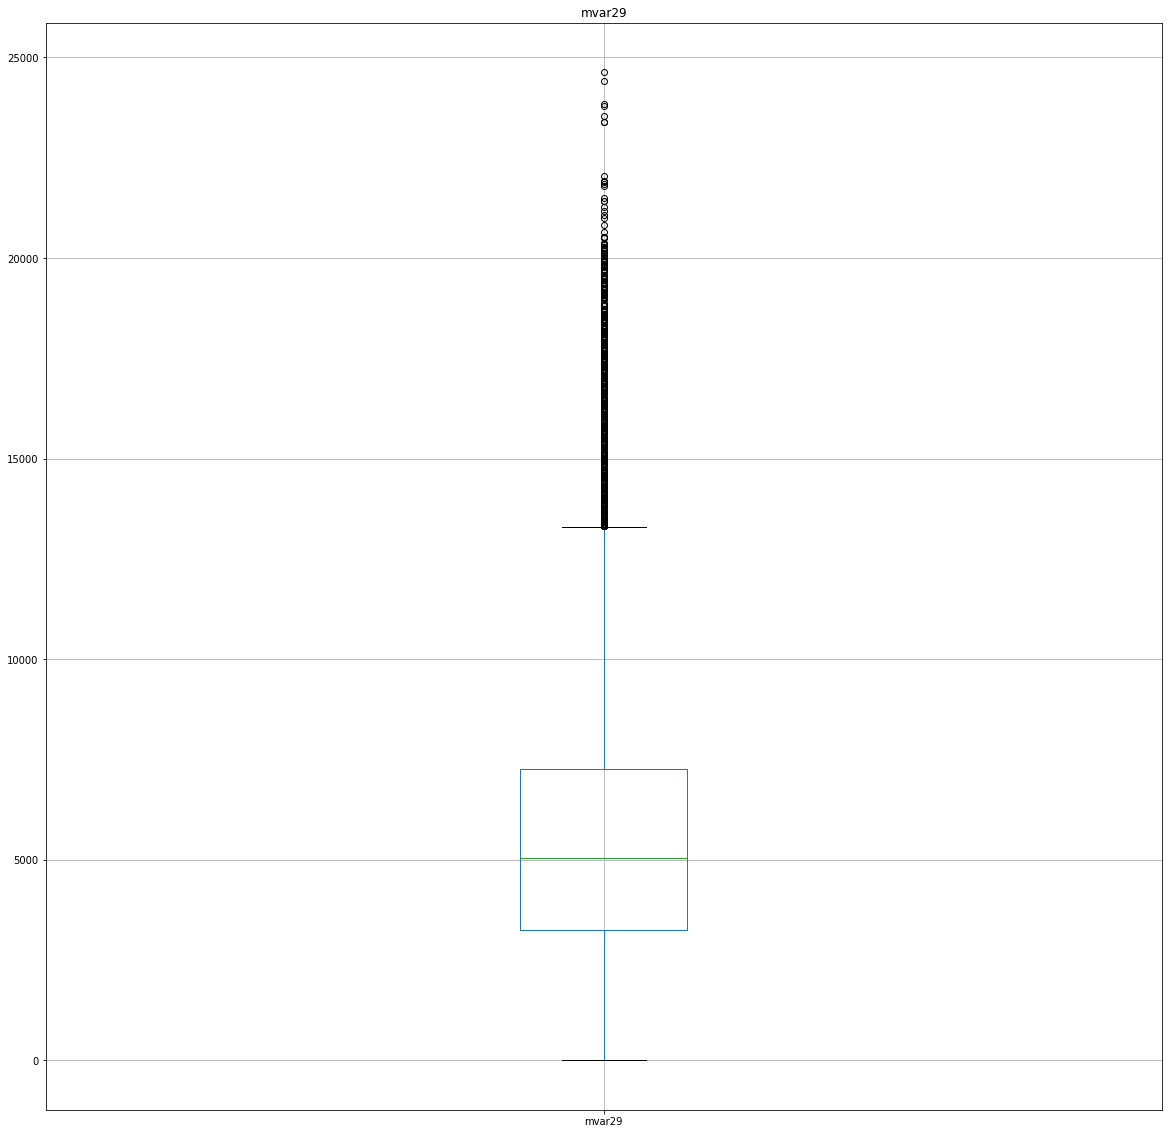

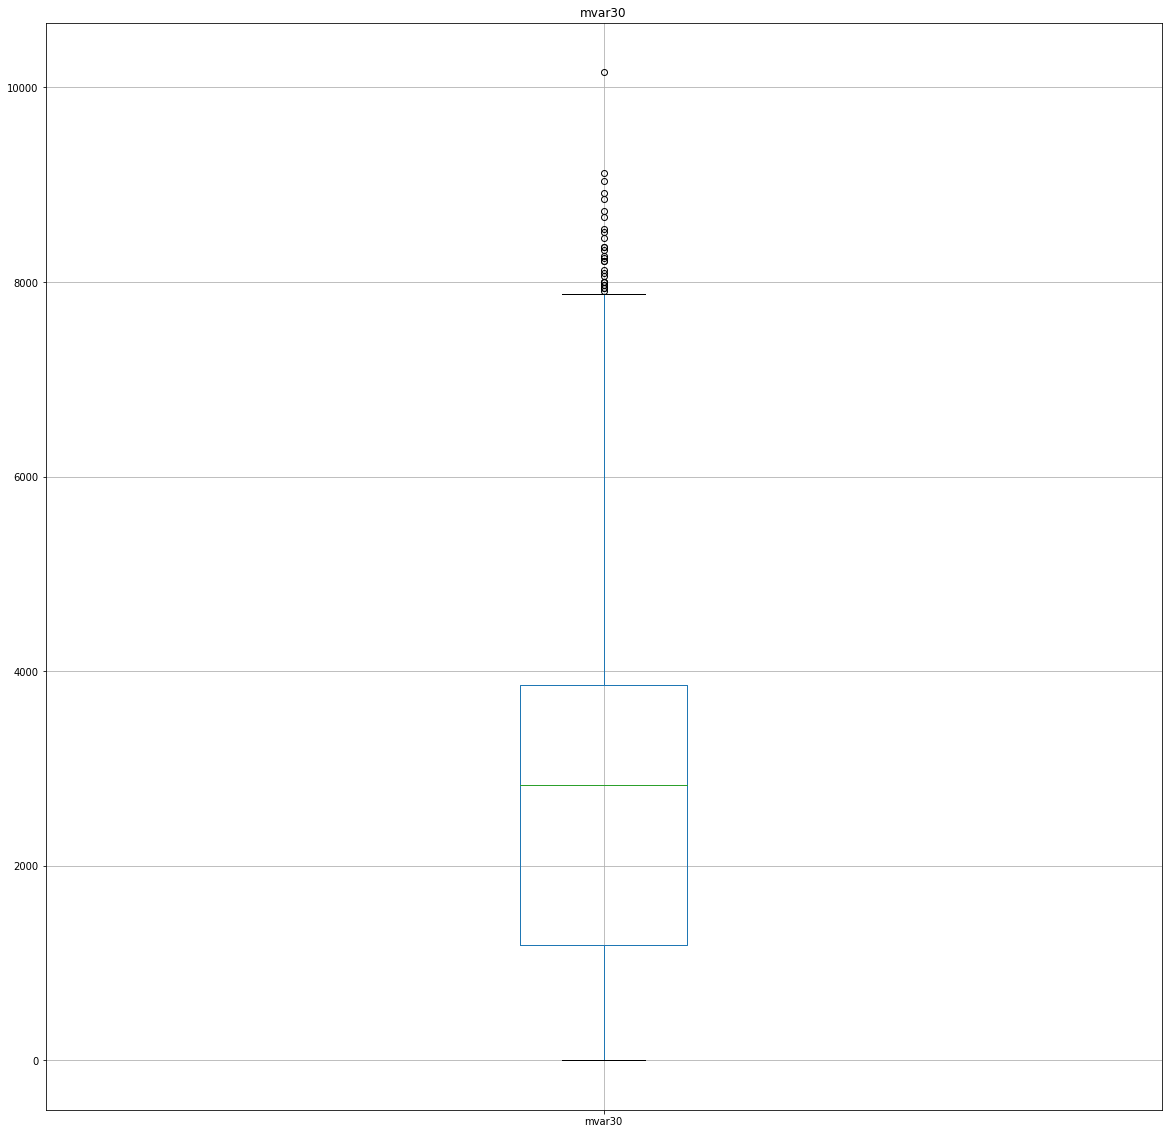

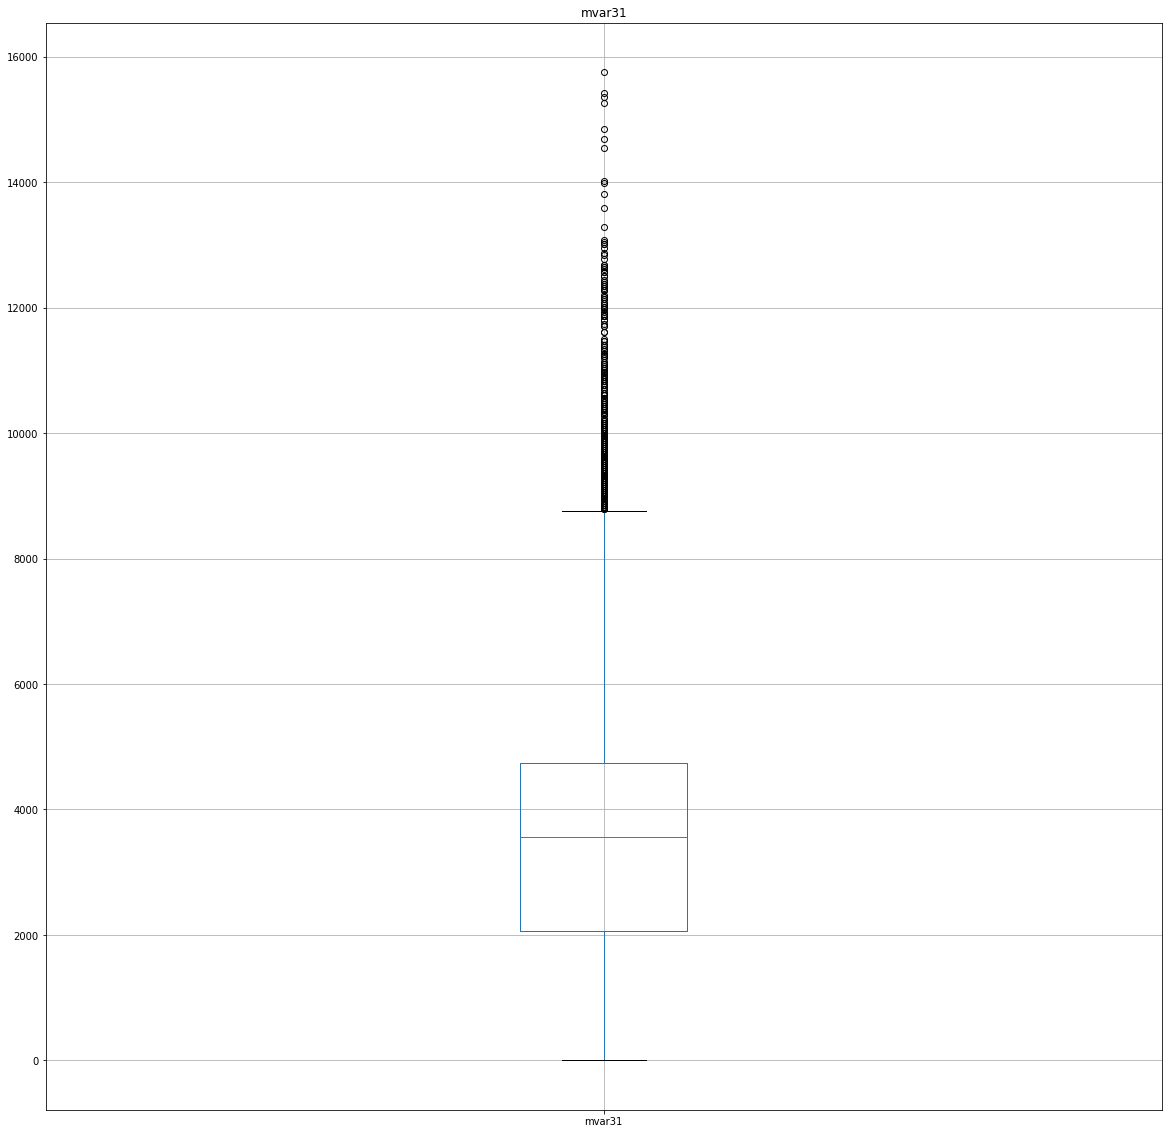

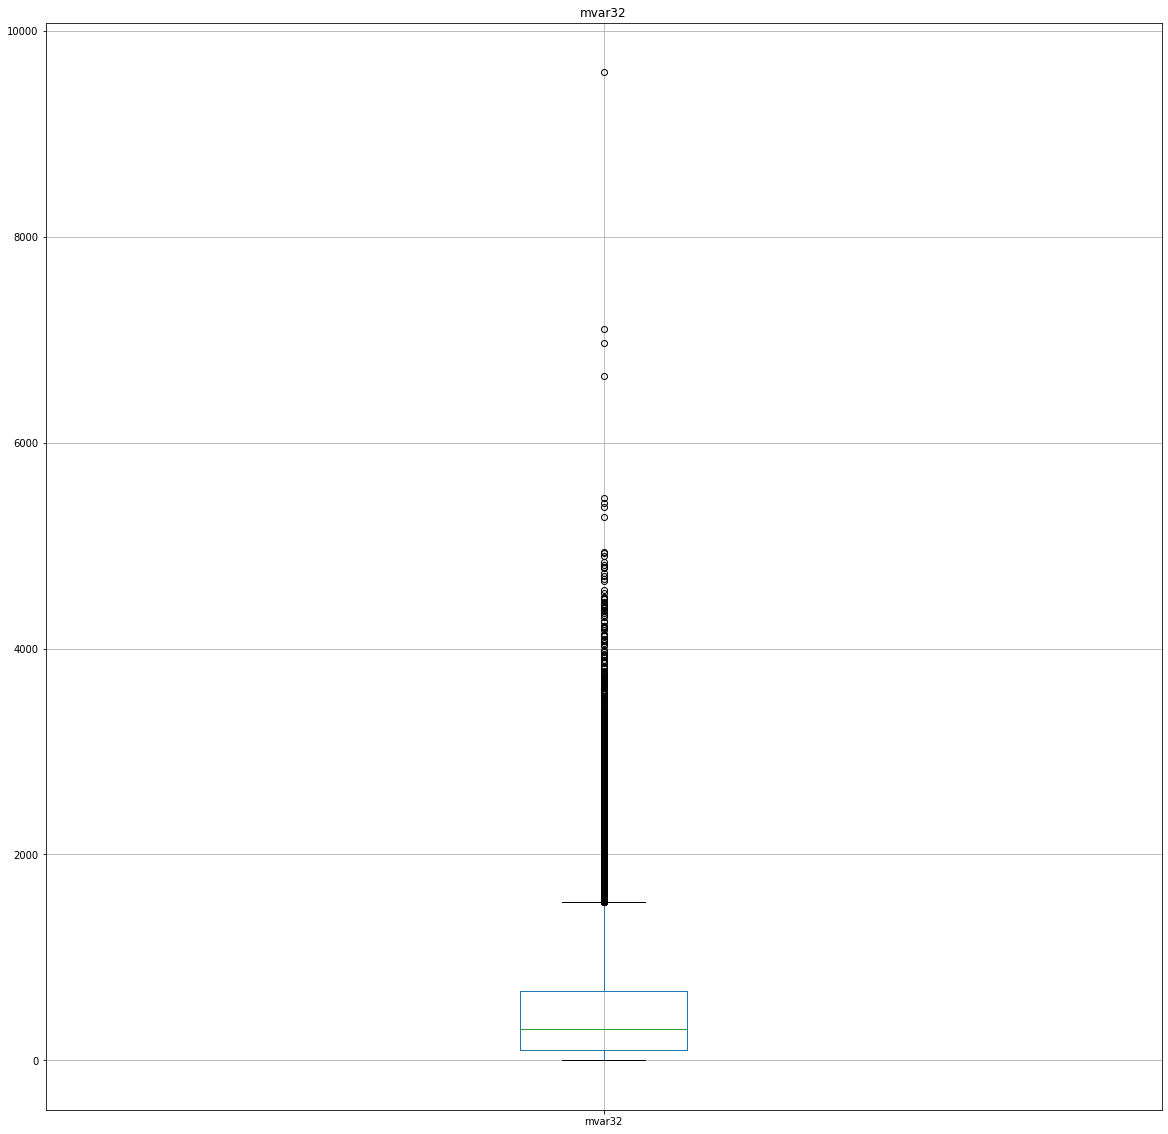

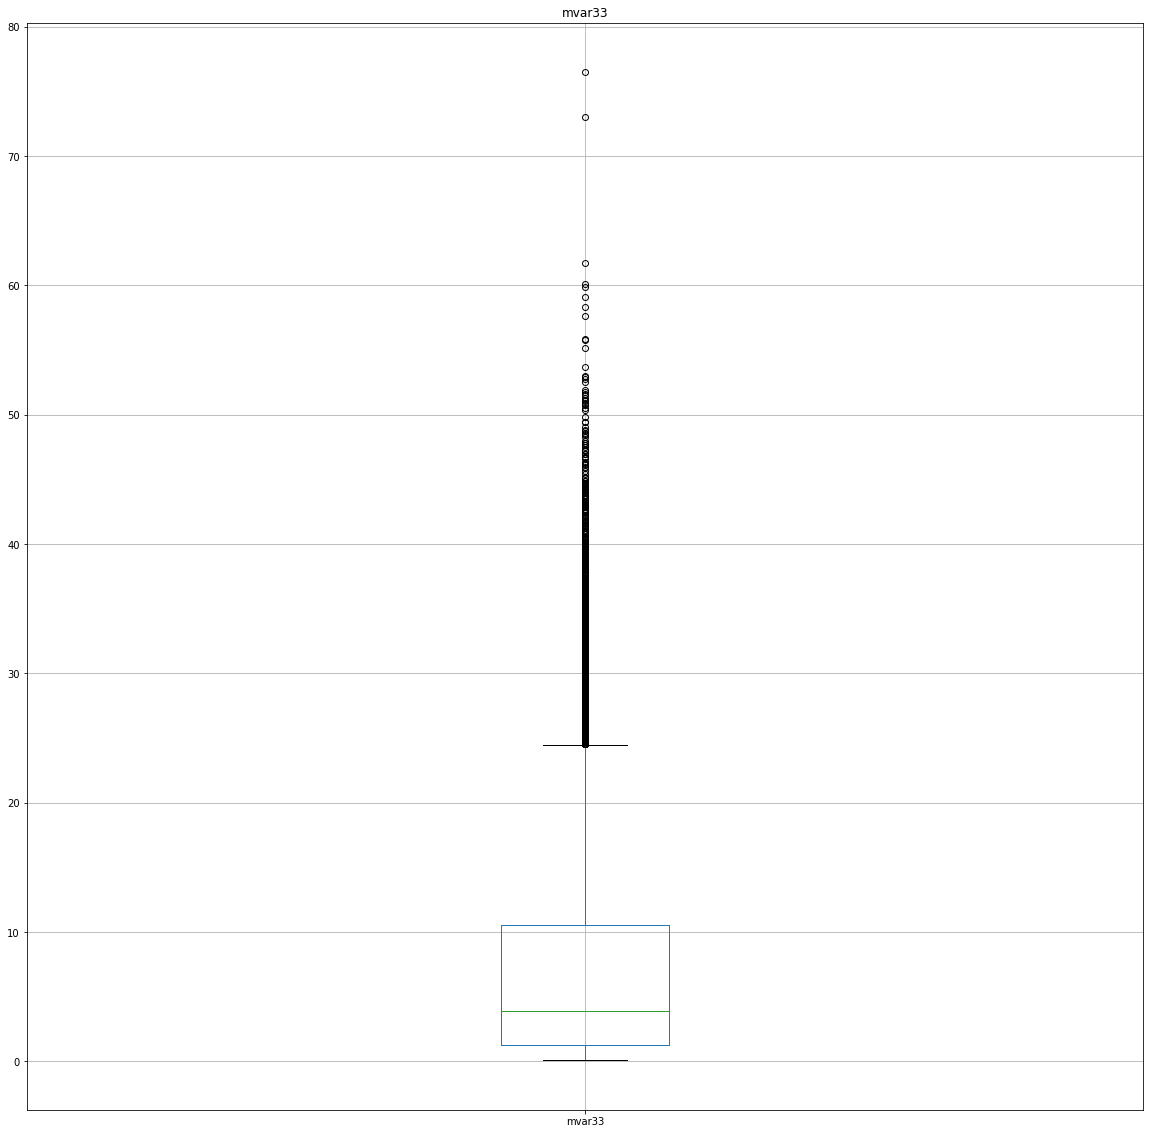

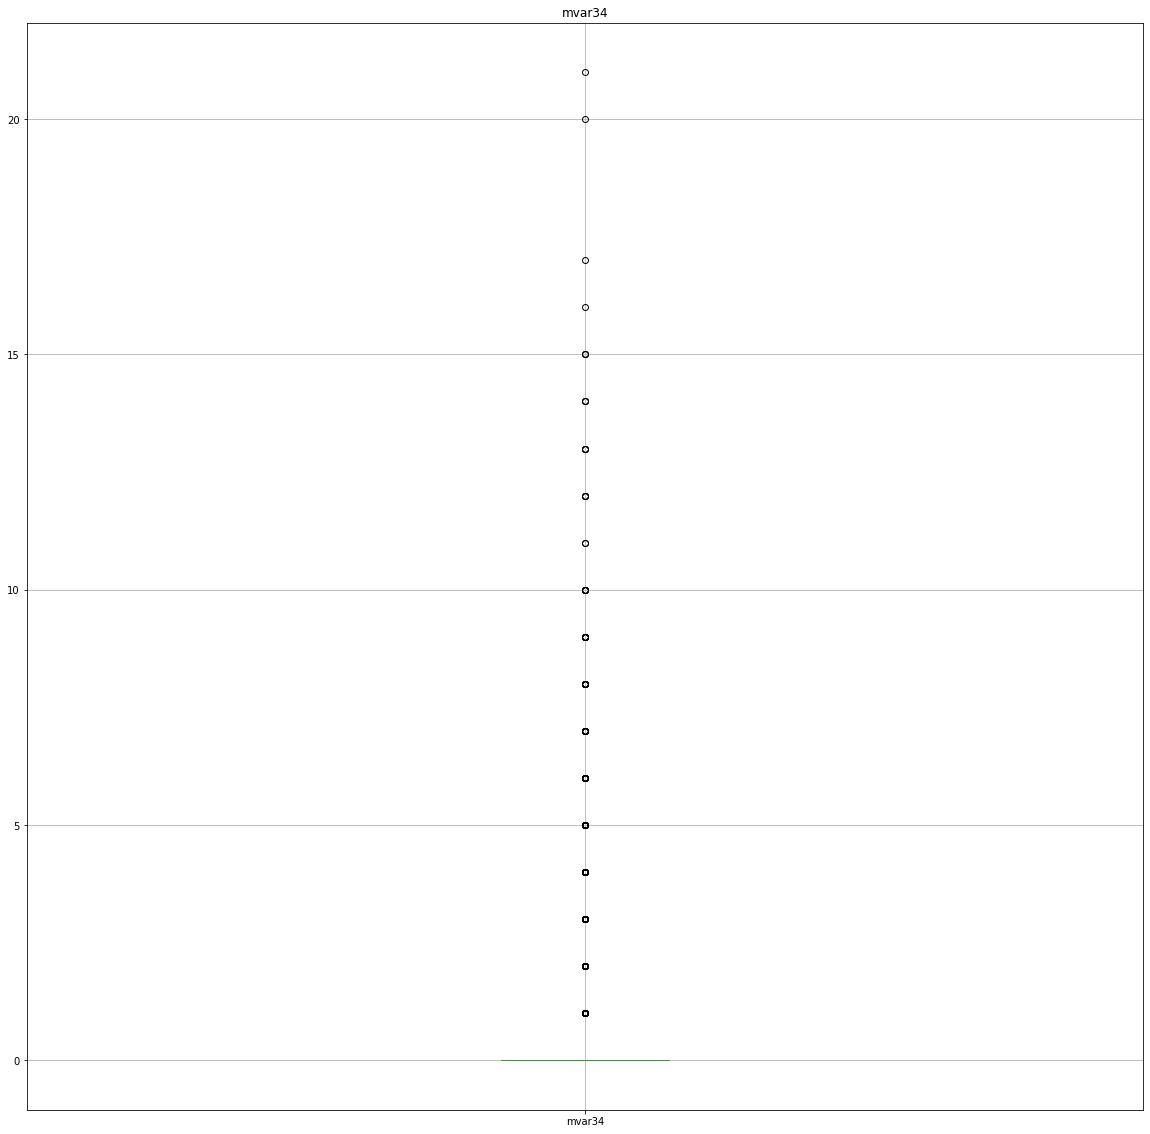

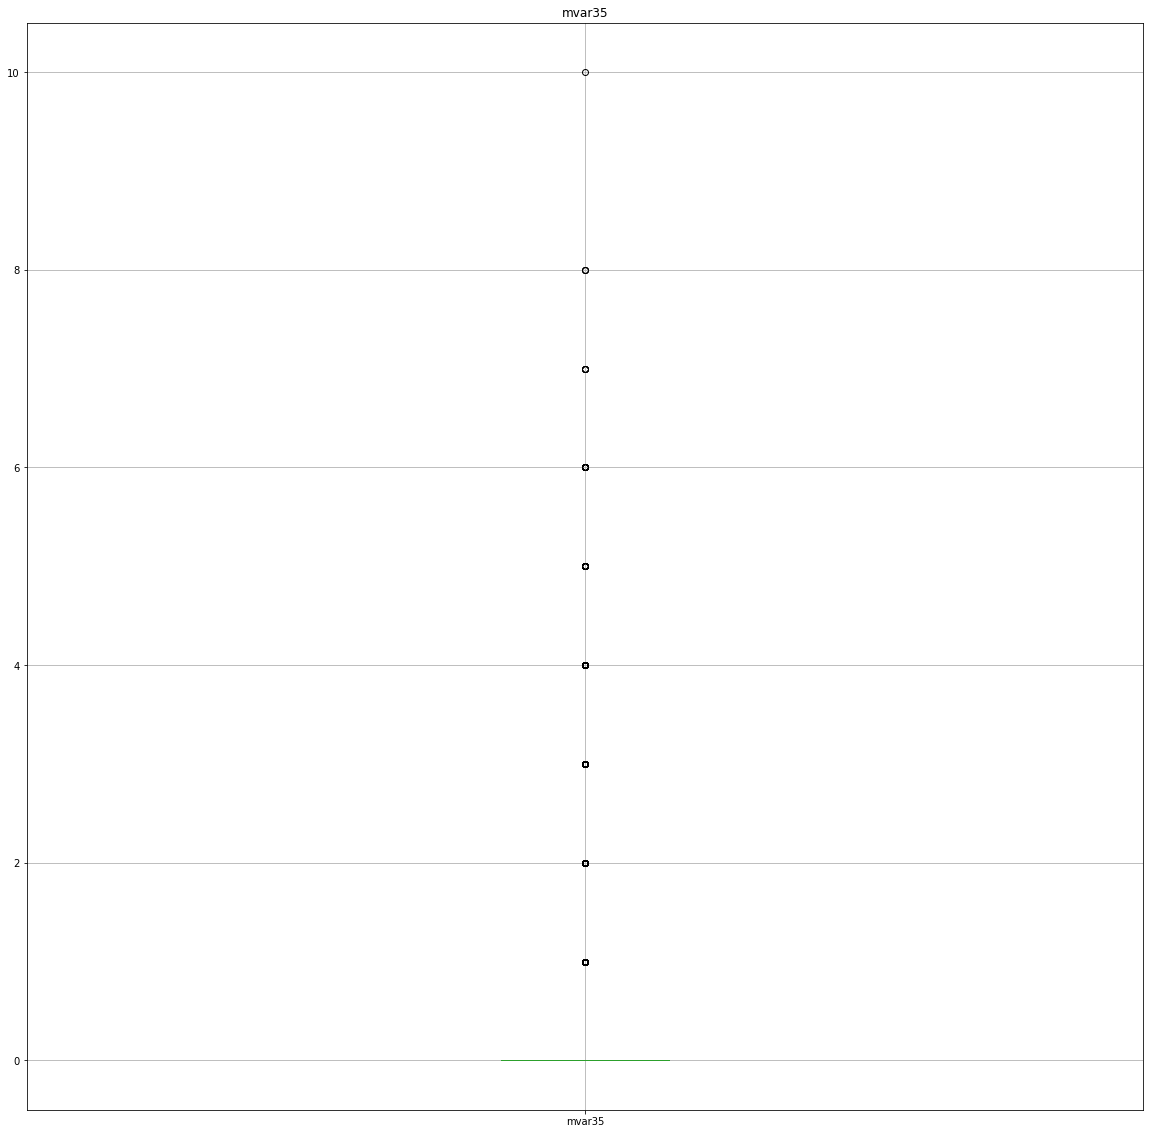

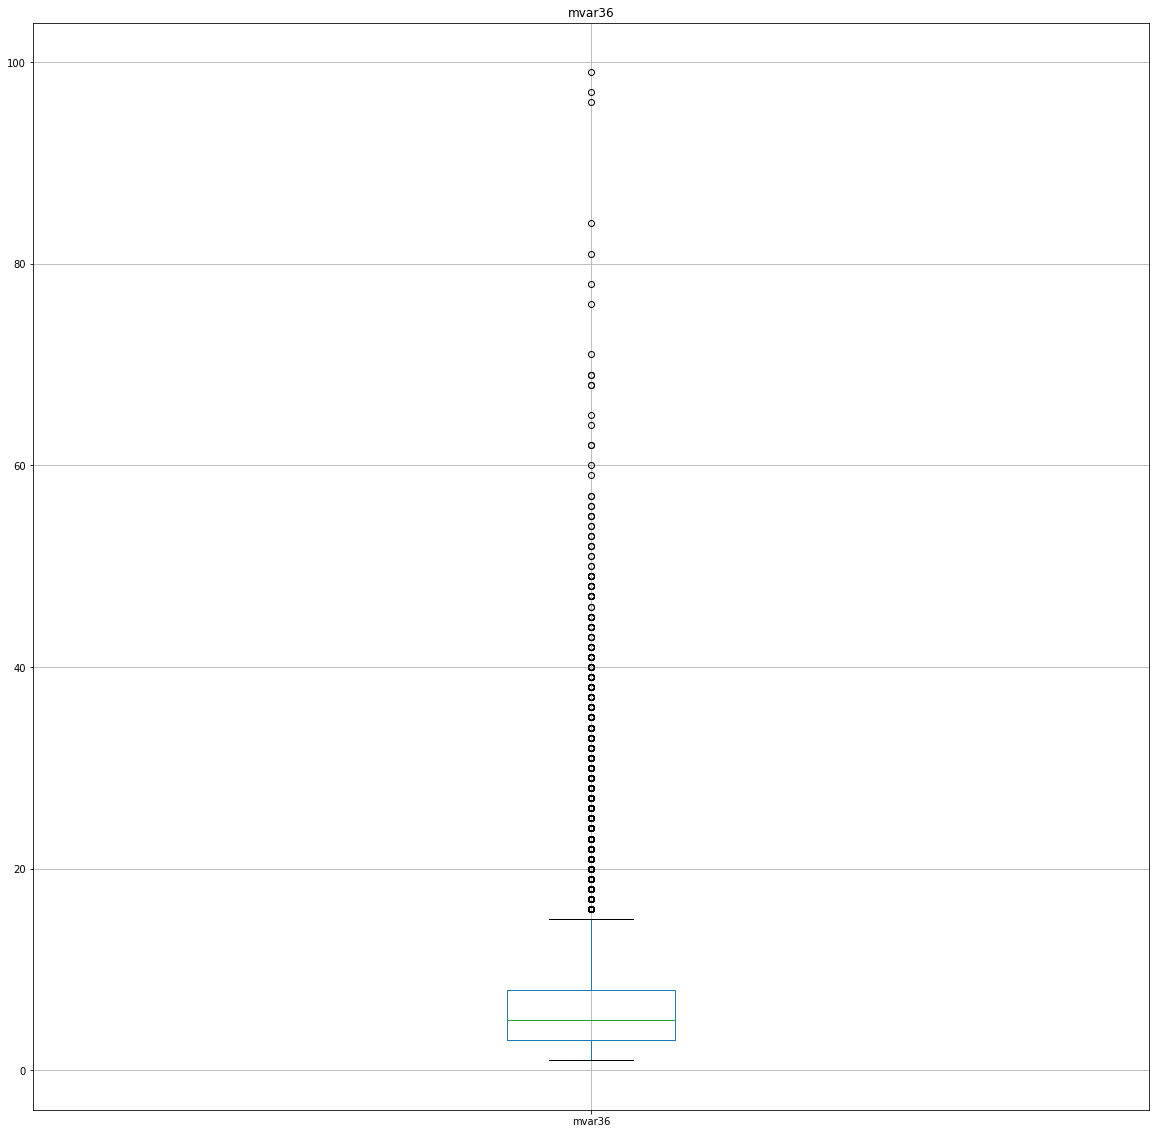

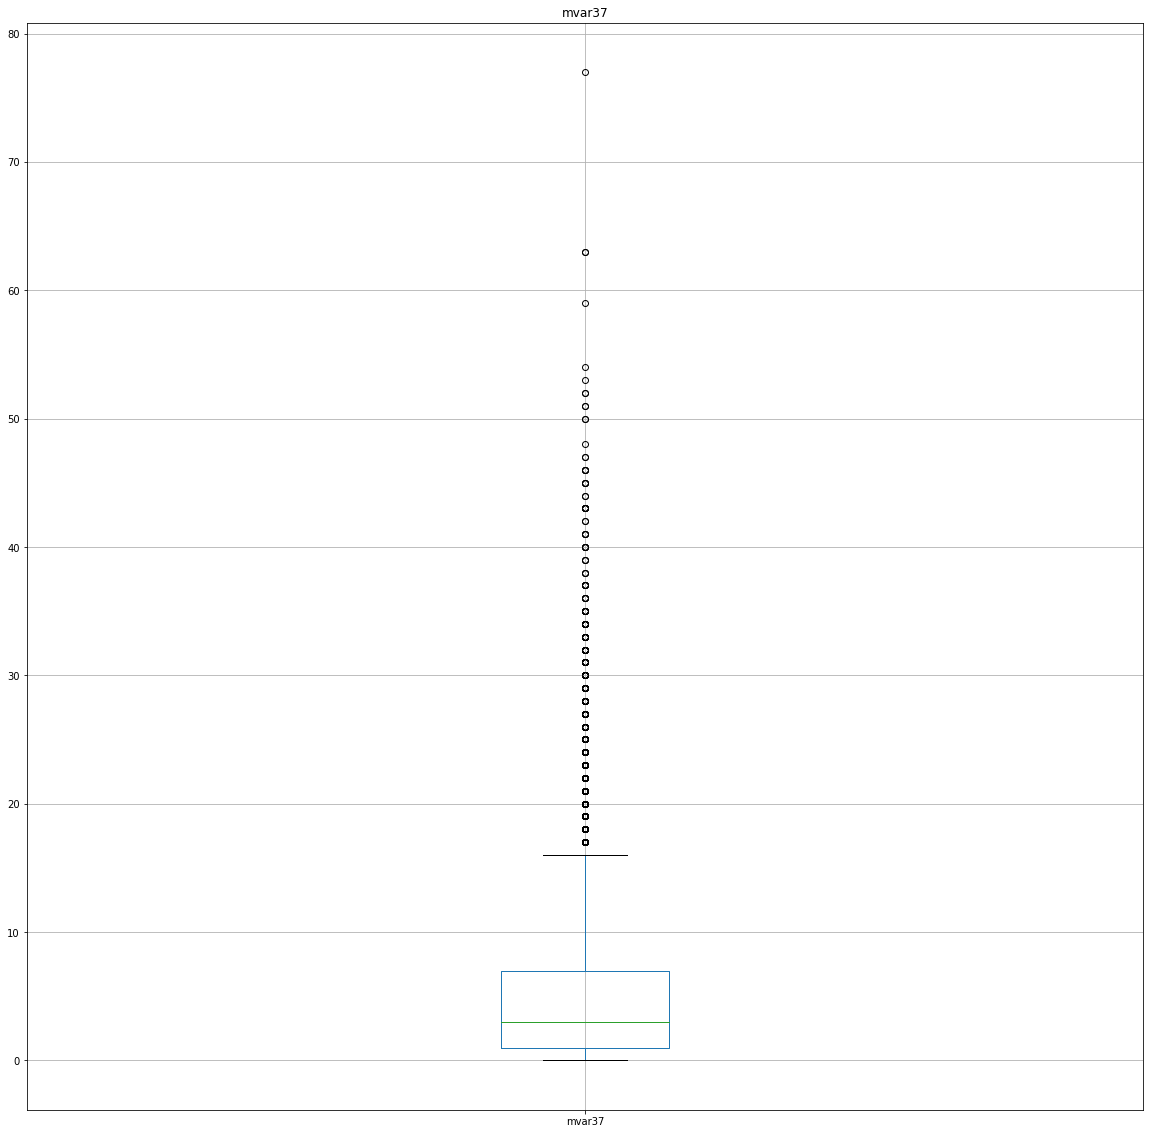

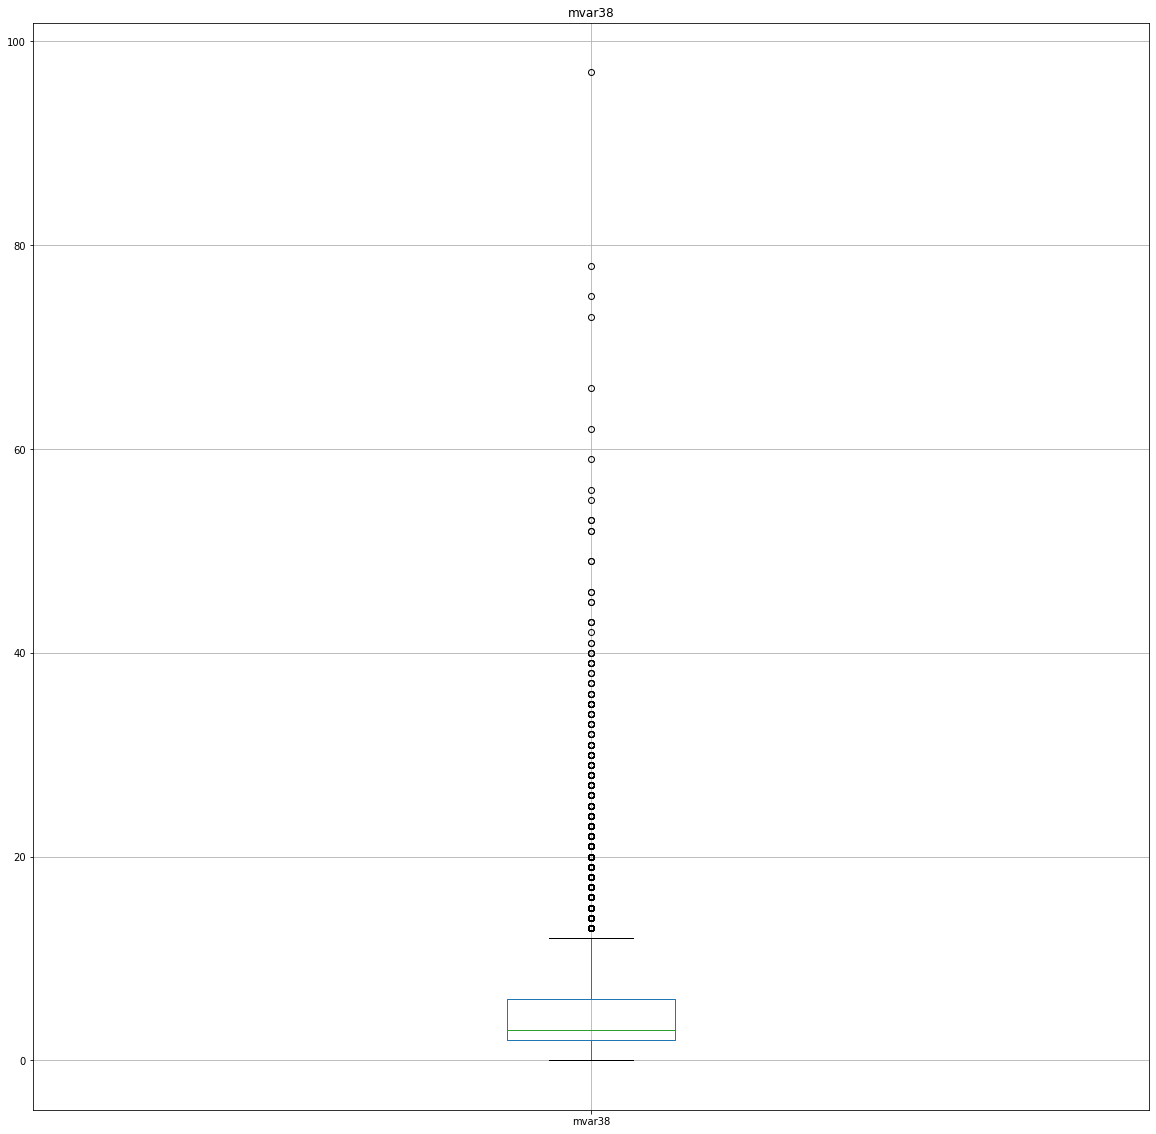

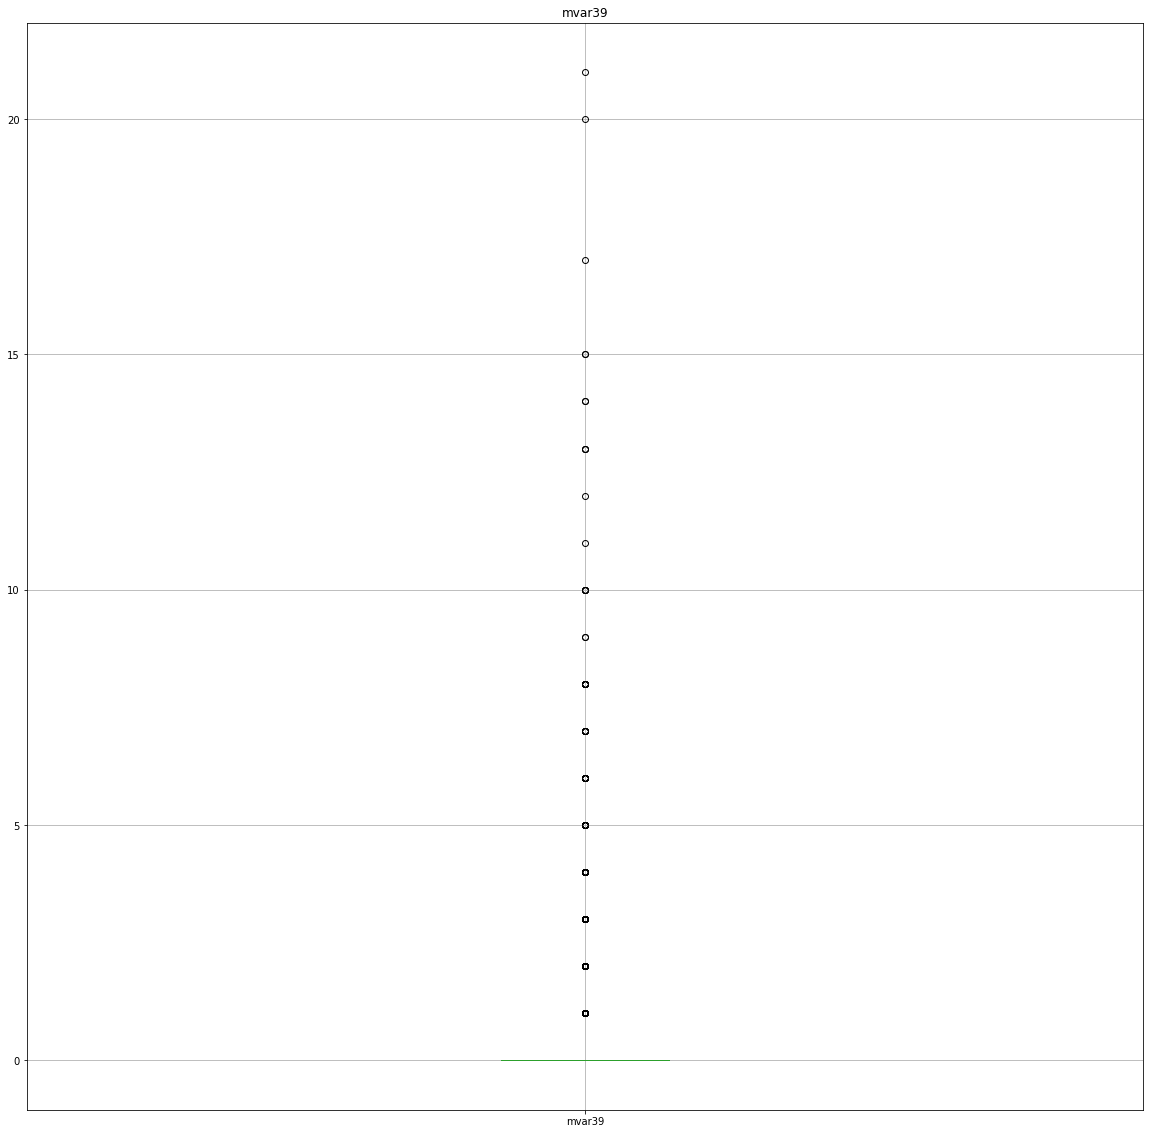

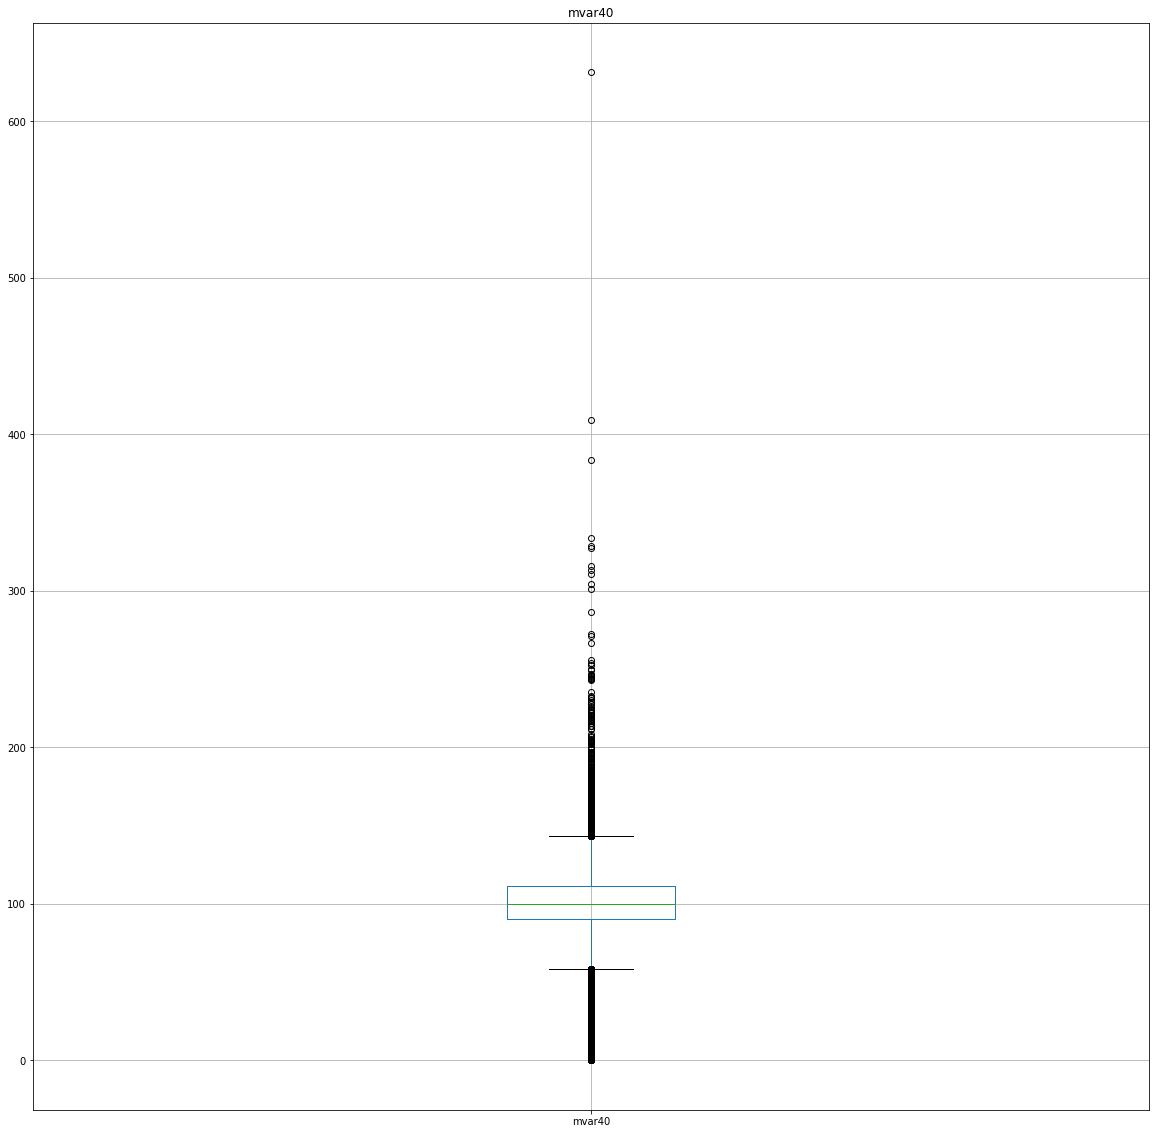

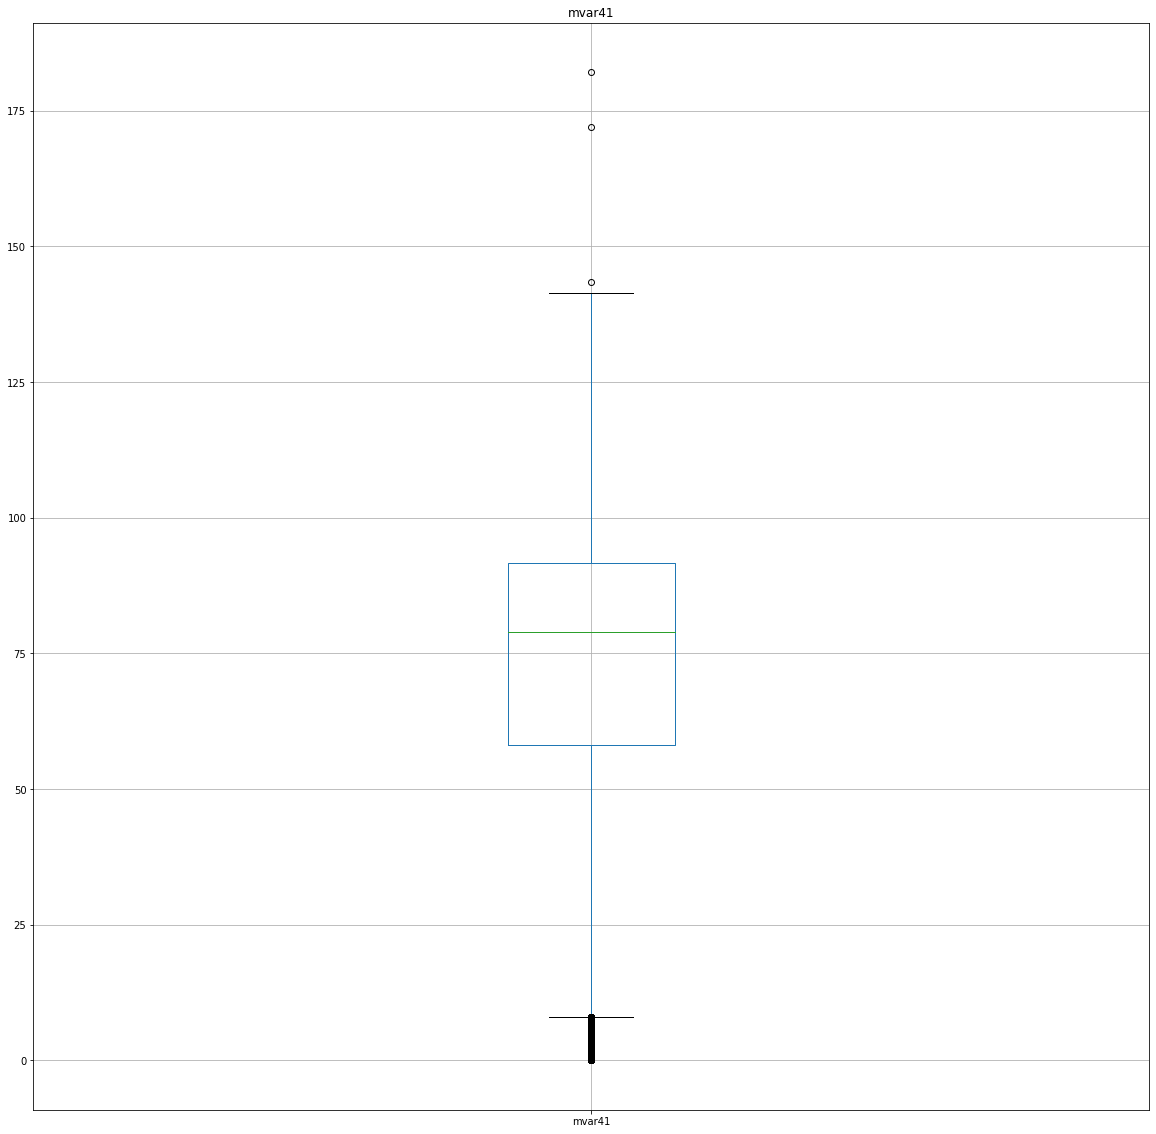

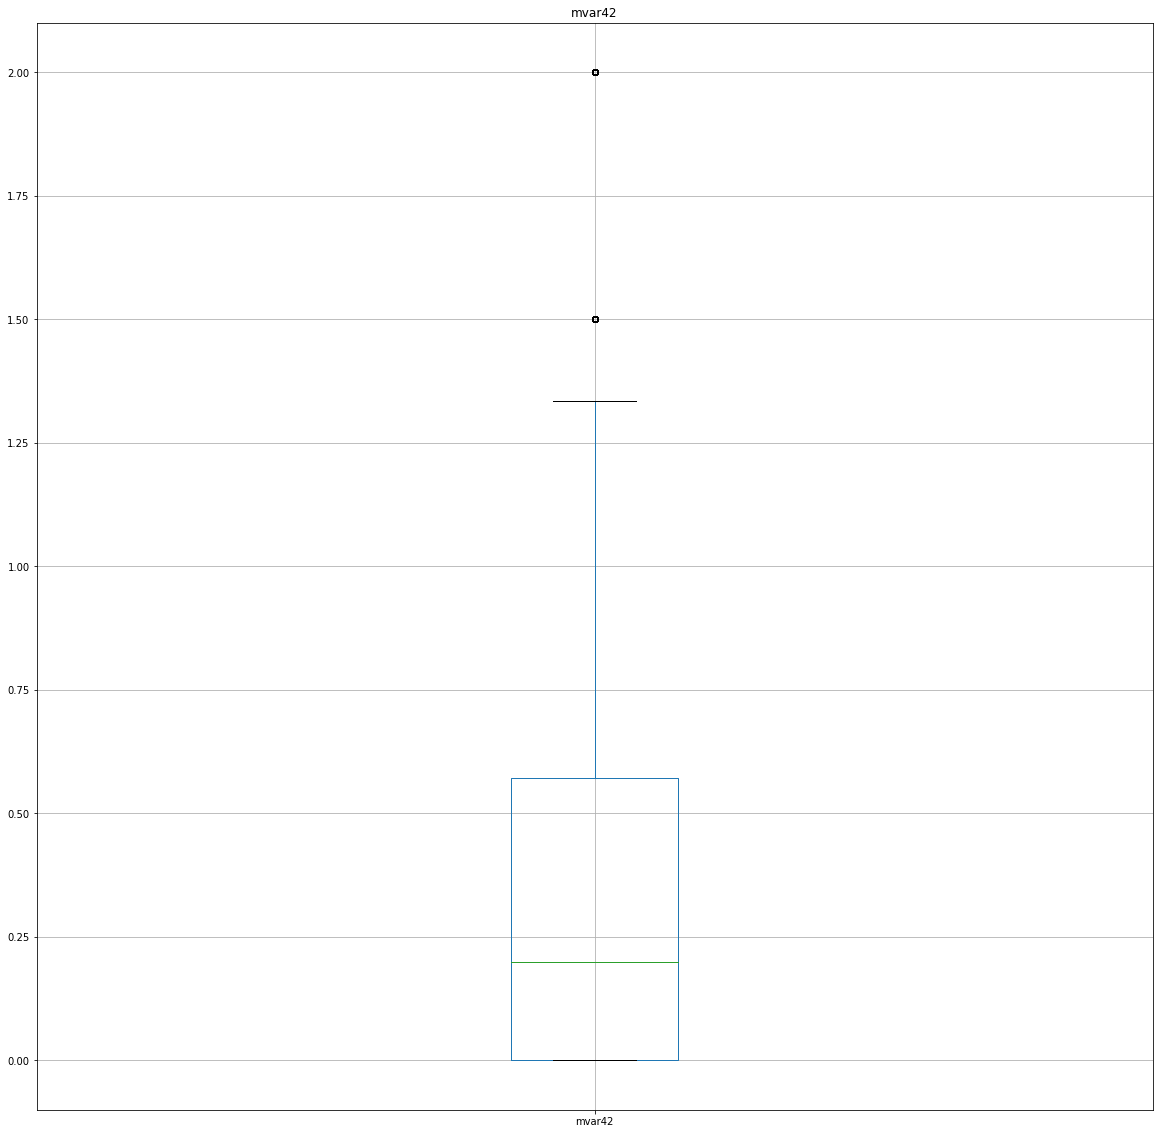

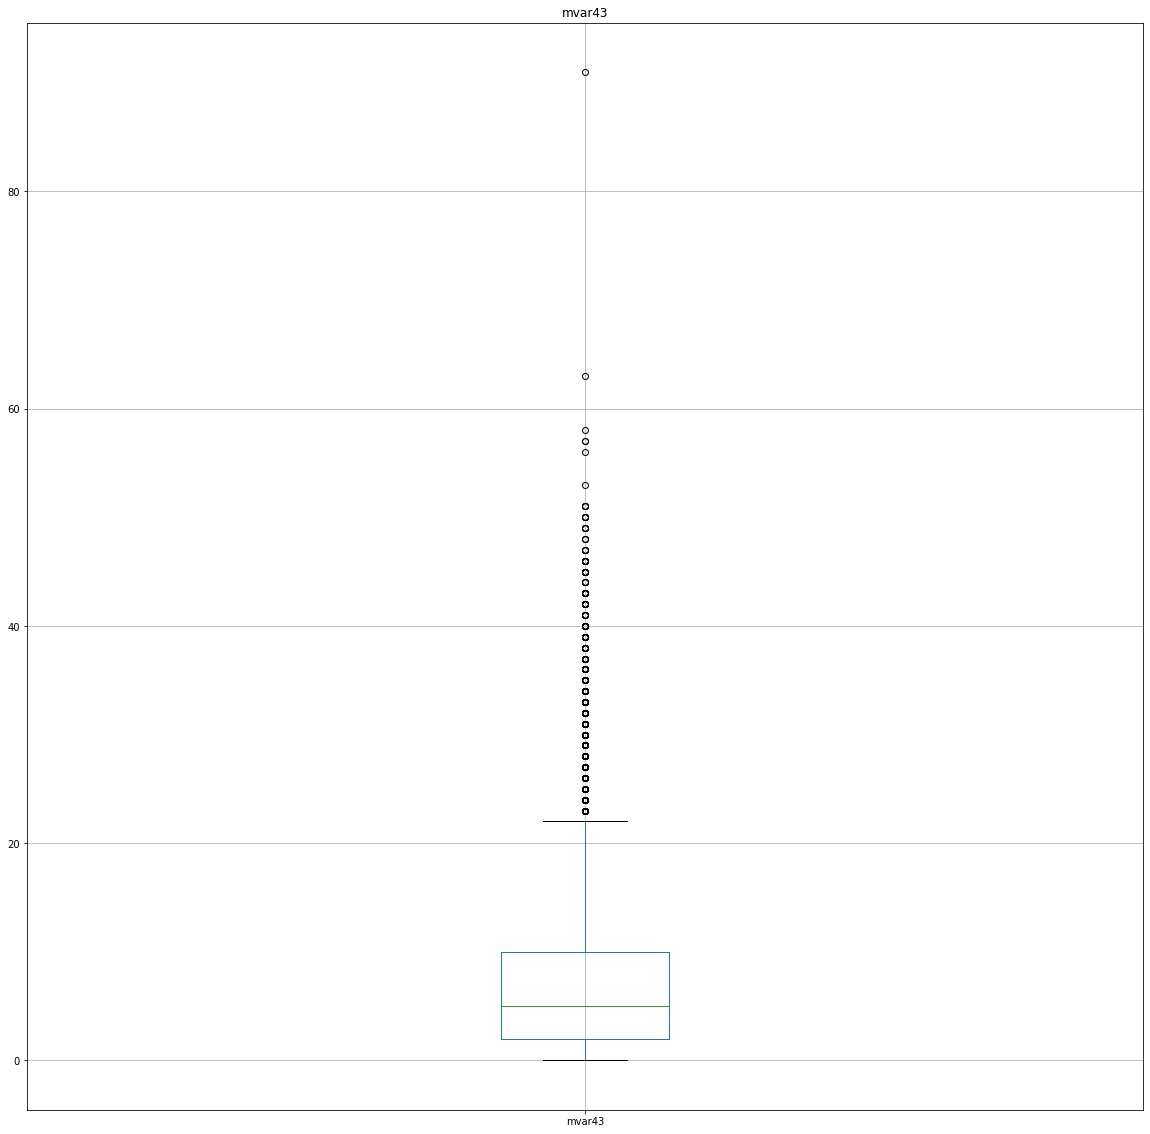

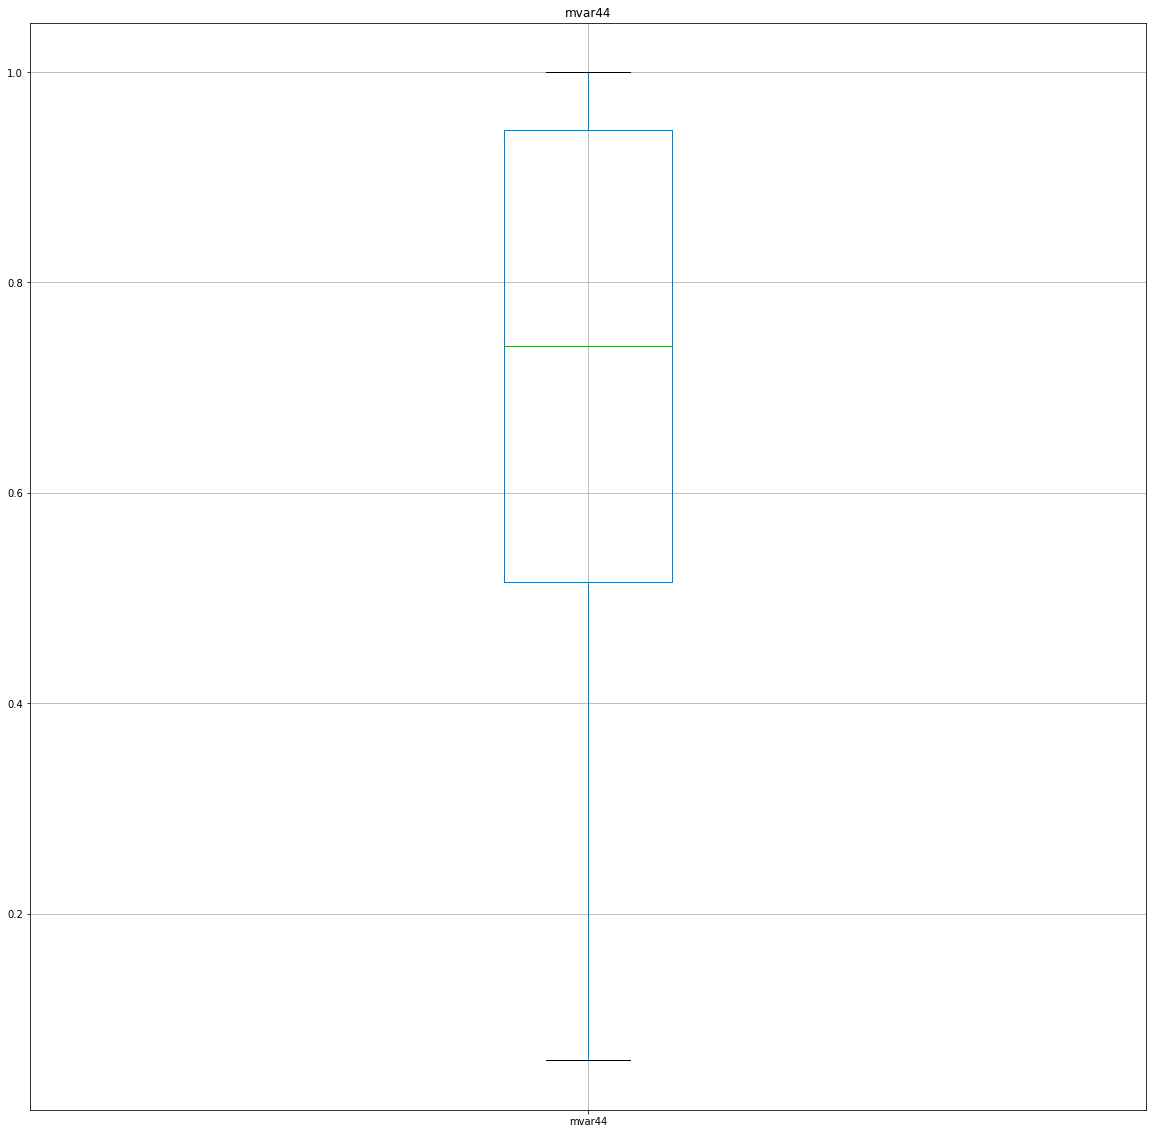

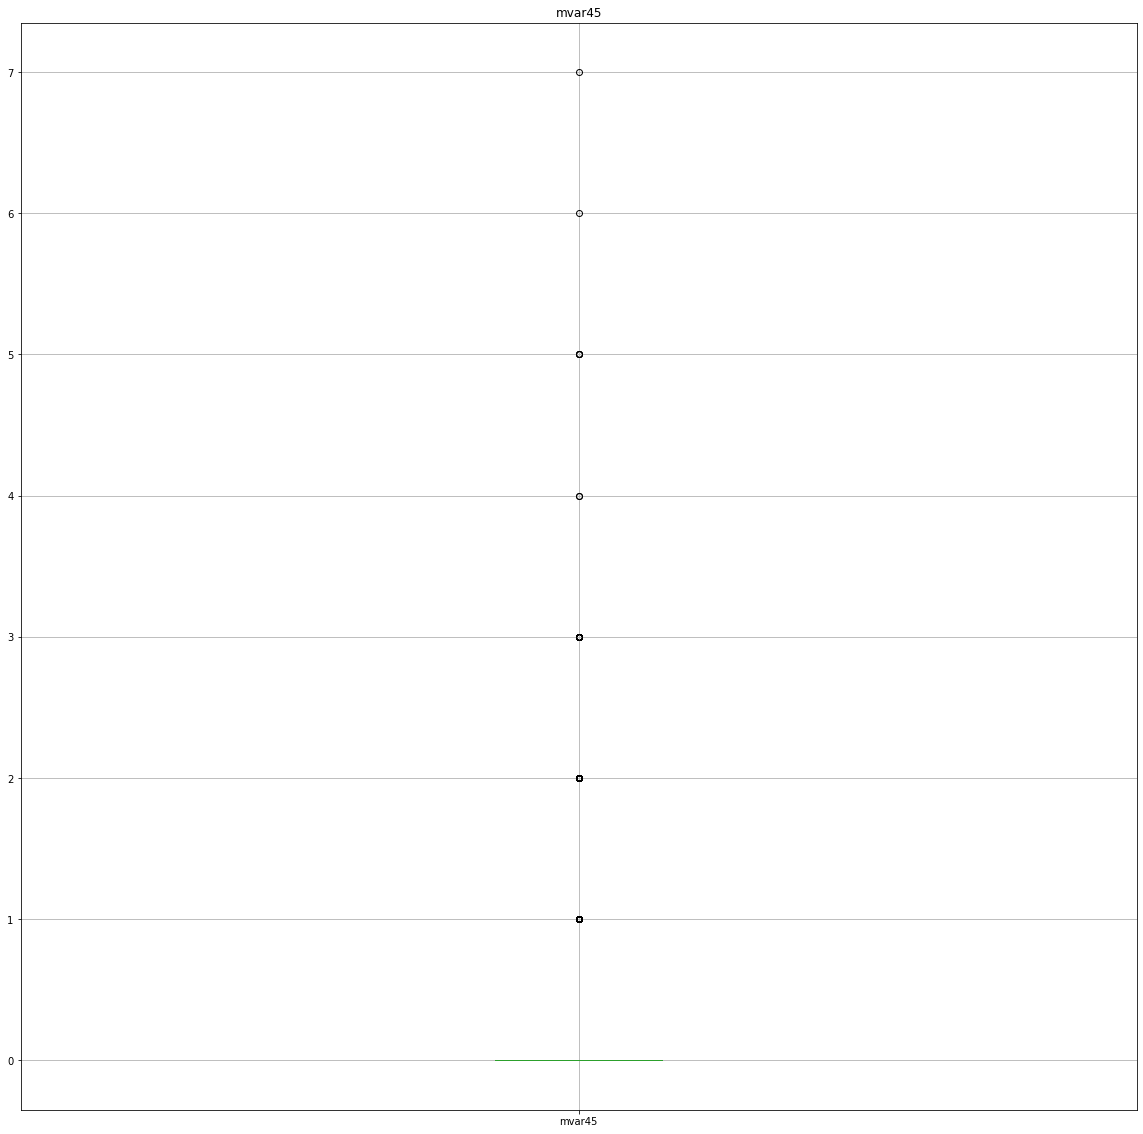

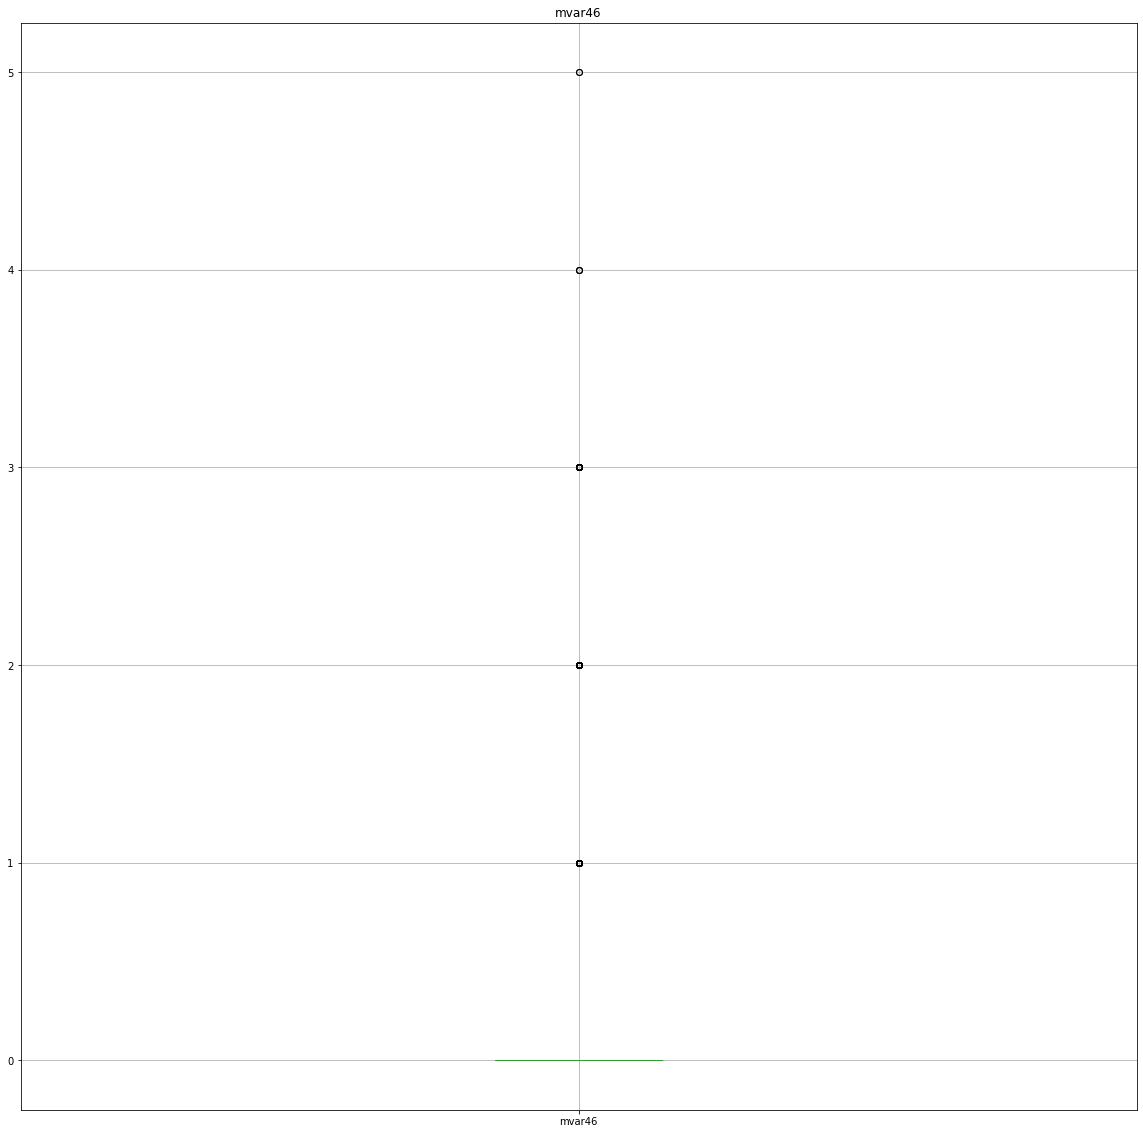

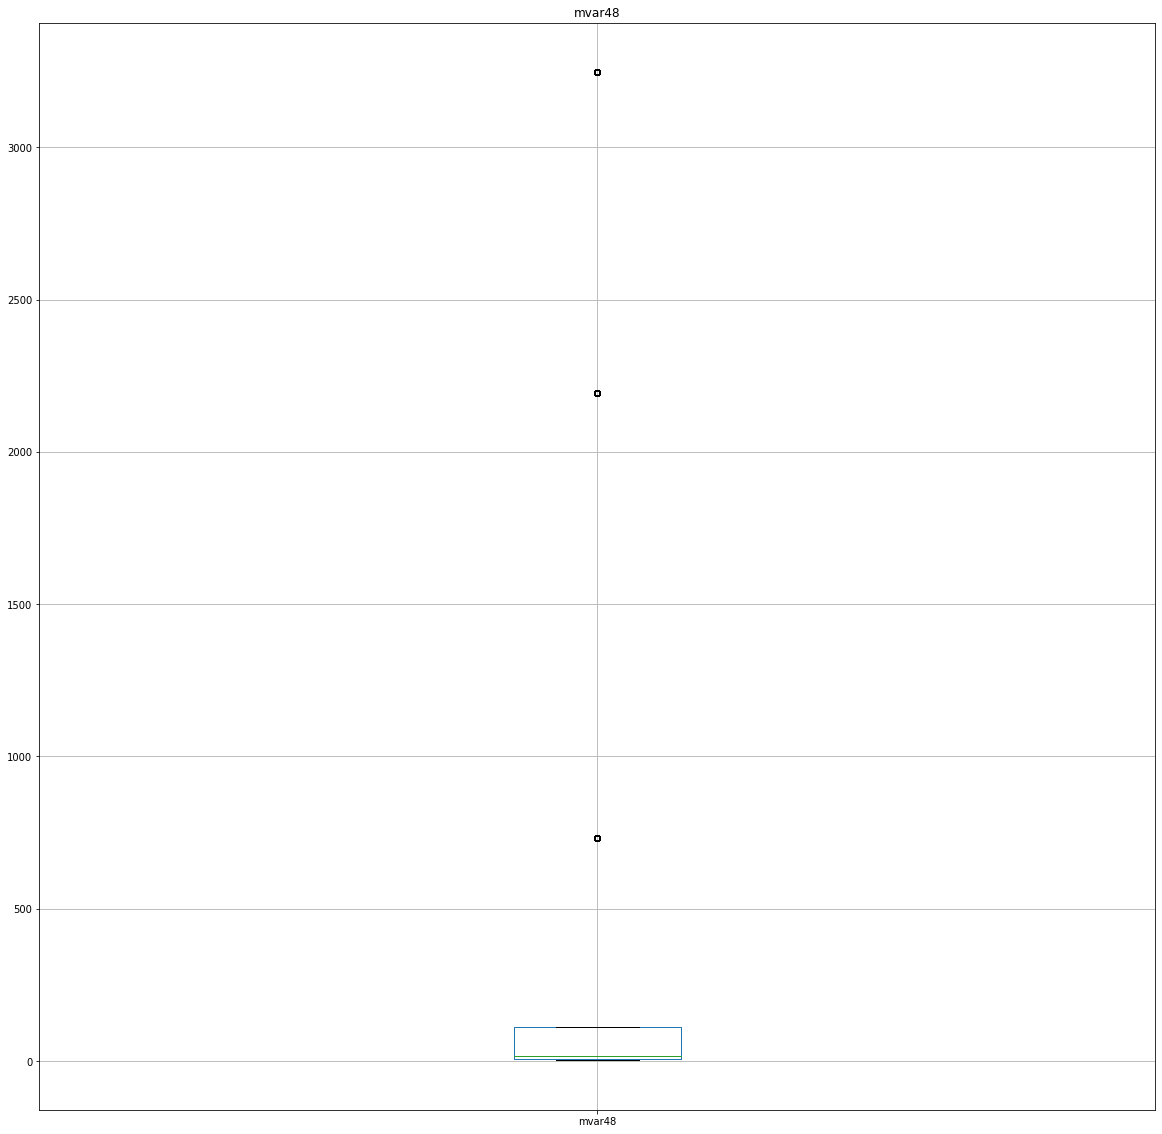

In [3]:
for i in range(1,49):
    if i!=47:
        plt.figure(figsize=[20,20])
        data.boxplot(column=['mvar{}'.format(i)])
        plt.title('mvar{}'.format(i))
        plt.show()

In [4]:
def RemoveOutlier(data):
    cutoffs = [2000,17,150,16,75,40000,1000000,100000,450000,1000000,250000,120000,1000000,0.06*10**9,0.4*10**7,6,8,8,15,20,300,30000,25000,6000,11500,19000,18000,35000,21000,8000,13200,5000,55,10,8,60,50,50,10,275,150,3,55,2,5,4,'random',4000]
    for i in range(len(cutoffs)):
        if (i!= 46):
            var = 'mvar' + str(i+1)
            data = data[~(data[var]>cutoffs[i])]
    return(data)

In [5]:
data_clean = RemoveOutlier(data)

print('The percentage values removed is {}'.format( round((len(data)-len(data_clean))/len(data)*100, 4) ))

The percentage values removed is 0.9024


In [6]:
y = data_clean['default_ind']

X_cols = list(data_clean.columns)
X_cols.remove('default_ind')

X = data_clean[X_cols]

### Normalize

In [7]:
categorical = ['mvar47', 'mvar48']
numeric = list(X.columns)

for var in categorical:
    numeric.remove(var)

In [8]:
X_Scaler = StandardScaler()
X_scaled = pd.DataFrame(X_Scaler.fit_transform(X[numeric]), columns=X[numeric].columns, index=X.index)
X_scaled[categorical] = X[categorical]

### Imputation

In [9]:
def basic_impute(data, cols, type_='mean'):
    
    if type_ == 'mean':
        return data.fillna(data[cols].mean()) 
    
    if type_ == 'median':
        return data.fillna(data[cols].median())
    
    if type_ =='mode':
        md = data[cols].mode()
        return data.fillna(md.iloc[0]) 
    
    if type_ == 'CF': #CF - Customer friendly
        imp_vals = data.mean()
        v = [40,31,41,45,35,46,24,16,17,18,12,9,39,2,42,43]
        for i in v:
            imp_vals['mvar'+str(i)] = 0
        med = data.median()
        imp_vals['mvar11'] = med['mvar11']
        
        return data.fillna(imp_vals[cols])    

In [13]:
def KNN_impute(cols_to_impute, X, numeric, train_na_method='mean'):
    
    result = X.copy()

    X_nonan = basic_impute(X, X.columns, type_=train_na_method)

    for col in cols_to_impute:

        X_train = X_nonan.loc[~X[col].isna()].drop(col, axis=1)
        y_train = X_nonan.loc[~X[col].isna(), col]

        X_test = X_nonan.loc[X[col].isna()].drop(col, axis=1)
        
        if len(X_test) == 0:
            print('No need to impute', col)
            continue
        
        print(col, ': Number of NaNs -', len(X_test))
        
        # 0.1 % of the data as neighbours
        model = KNeighborsRegressor(int(0.001*len(X_train)))
        model.fit(X_train, y_train)

        result.loc[X_test.index, col] = model.predict(X_test)
        
        print('Imputed for', col)
        
    return result

In [15]:
cols_to_impute = numeric # Choose columns you want to impute using the KNN method

X_scaled_imputed = KNN_impute(cols_to_impute, X_scaled[numeric], numeric, train_na_method='CF')

mvar1 : Number of NaNs - 3718
Imputed for mvar1
mvar2 : Number of NaNs - 5834
Imputed for mvar2
mvar3 : Number of NaNs - 534
Imputed for mvar3
mvar4 : Number of NaNs - 534
Imputed for mvar4
mvar5 : Number of NaNs - 534
Imputed for mvar5
mvar6 : Number of NaNs - 19506
Imputed for mvar6
mvar7 : Number of NaNs - 7585
Imputed for mvar7
mvar8 : Number of NaNs - 19513
Imputed for mvar8
mvar9 : Number of NaNs - 11580
Imputed for mvar9
mvar10 : Number of NaNs - 534
Imputed for mvar10
mvar11 : Number of NaNs - 46310
Imputed for mvar11
mvar12 : Number of NaNs - 14447
Imputed for mvar12
mvar13 : Number of NaNs - 9620
Imputed for mvar13
No need to impute mvar14
mvar15 : Number of NaNs - 33196
Imputed for mvar15
mvar16 : Number of NaNs - 19055
Imputed for mvar16
mvar17 : Number of NaNs - 16337
Imputed for mvar17
mvar18 : Number of NaNs - 15209
Imputed for mvar18
mvar19 : Number of NaNs - 5
Imputed for mvar19
mvar20 : Number of NaNs - 534
Imputed for mvar20
mvar21 : Number of NaNs - 23244
Imputed fo

In [23]:
X_scaled_imputed[categorical] = X_scaled[categorical]
X_scaled_imputed['default_ind'] = y
X_scaled_imputed.to_csv('Data\Training_scaled_imputed.csv')
